In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import random, mlx_lm, math, scipy, pickle, os
from functools import partial
from itertools import starmap
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from sklearn.decomposition import PCA

import gemma2

# Introduction

This notebook is a tutorial based on Engels et al. "Not All Language Model Features Are Linear" (https://arxiv.org/abs/2405.14860)

SAE's have emerged as a method for extracting information about the internal representations of language models. In this section we will look at the behaviour of this method on simple datasets. This excercise will give us the intuition to understand the theory presented in the paper. The content of this section corresponds to Appendix D in the paper.

As a reminder according to the Linear Superposition Hypothesis, the meaning of a token is represented in the residual stream of a transformer as a superposition of vectors that correspond to features of the token. For example we can think of the representation of the word "dog" as a superposition of two vectors that correspond to 1) the "dog-ness" of the word and 2) the language of the word, English in this case.

Training a SAE on the residual stream we hope to recover these features. The SAE consists of a set of dictionary elements that are themselves vectors in the residual stream. Applying an SAE to the residual stream for a particular token will yield an activation for each dictionary element that presents how strongly the given feature is present.

The above picture is a caricature of the theory behind the SAE's and the Linear Superposition Hypothesis. In this telling the internal representation is inherently one-dimensional. In the paper the authors explore this notion and show that certain concepts are represented in more than one dimension.

## Setup

Here are some commands to verify that the environment is correctly set up. It will download the model weights and generate some sample text:

In [103]:
model, tokenizer = gemma2.load()
mlx_lm.utils.generate(model, tokenizer, "Hello")

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

',\n\nI have a problem with the following code:\n\n<code>\n#include <iostream>\n#include <string>\n#include <vector>\n#include <algorithm>\n#include <iterator>\n#include <fstream>\n#include <sstream>\n#include <iomanip>\n#include <cmath>\n#include <ctime>\n#include <cstdlib>\n#include <cctype>\n#include <cstring>\n#include <cstdio>\n#'

# Toy Case

In this first section we look at simplified toy cases, to gain insight into how a SAE represents a dataset. The purpose of this section is to gain the intuition to understand the theory that is presented in the paper.

We will do so in three steps:
1. in the simplest case of having a single concept that is represented in two dimensions by the smallest SAE that could capture this concept.
2. a larger SAE where the encoder has more capacity than strictly necessary
3. a final case where two separate concepts are to be represented by the same SAE.

## Single Circular Dataset

To begin with we will be looking a very simple case where the data points are distributed uniformly along the unit circle. This is inherently a two-dimensional dataset. In order to faithfully represent this data using an SAE we will need (at least) two dictionary elements. Remember that a dictionary element is a vector and we need at least two vectors to represent all points of a circle.

### Complete Case

In this first example we generate random samples of points on the unit circle. We then train a SAE with two dictionary elements on this data. We will then visualize the dictionary elements and the activations of the SAE on the data. After training the dictionary elements should be two unit vectors that are perpendicular to each other. The activations of the SAE on the data should be a linear combination of these two vectors.

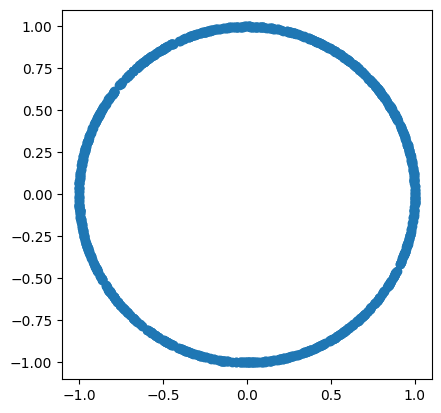

In [6]:
def random_points_on_unit_circle(N, offset=(0, 0)):
  angles = 2 * np.pi * np.random.rand(N)
  x = np.cos(angles) + offset[0]
  y = np.sin(angles) + offset[1]
  return np.column_stack((x, y))

unit_circle_points = random_points_on_unit_circle(1000)
plt.scatter(unit_circle_points[:, 0], unit_circle_points[:, 1])
plt.gca().set_aspect('equal')
plt.show()

We create a simple class for the SAE which we will use for our experiments in this section. Read through the source code and make sure you understand it.

In [9]:
class SAE(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super(SAE, self).__init__()
    self.encoder = nn.Linear(input_dim, hidden_dim)
    self.decoder = nn.Linear(hidden_dim, input_dim)

  @property
  def dict_elements(self):
    return self.decoder.weight / mx.linalg.norm(self.decoder.weight, axis=0, keepdims=True)

  def normalize_decoder_columns(self):
    W_norm = mx.sqrt(mx.sum(self.decoder.weight**2, axis=0, keepdims=True))
    self.decoder.weight /= W_norm

  def __call__(self, x):
    acts = nn.relu(self.encoder(x - self.decoder.bias))
    return acts, self.decoder(acts)

  def draw_dict_elements(self, plt):
    dict_elements = self.dict_elements
    for i in range(dict_elements.shape[1]):
      plt.quiver(0, 0, dict_elements[0, i], dict_elements[1, i], angles='xy', scale_units='xy', scale=1, color='r')

  def loss_fn(self, X, sparsity_penalty):
    acts, reconst = self(X)
    recon_loss    = mx.mean(mx.power(reconst-X, 2), axis=1)
    sparsity_loss = mx.mean(mx.abs(acts))
    return mx.mean(recon_loss + sparsity_penalty*sparsity_loss)

  def train(self, Xs, sparsity_penalty, lr=1e-3, max_iter=20000, batch_size=128):
    """
    Xs: list of input datasets, they will be sampled uniformly
    """
    mx.eval(self.parameters())
    loss_and_grad_fn = nn.value_and_grad(self, partial(self.loss_fn, sparsity_penalty=sparsity_penalty))
    optimizer        = optim.Adam(learning_rate=lr)

    if not isinstance(Xs, list):
      Xs = [Xs]

    with tqdm(total=max_iter, desc="Training", unit="iter") as pbar:
      for i in range(max_iter):
        X           = random.choice(Xs)      # why we do this will become clear later
        batch_idx   = np.random.choice(len(X), batch_size)
        x           = mx.array(X[batch_idx])
        loss, grads = loss_and_grad_fn(x)

        if i % 100 == 0:
          pbar.set_postfix({"Loss": loss.item()})

        optimizer.update(self, grads)
        # after every update we normalize the decoder columns, this messes with the optimisation, but over time the training adjusts
        self.normalize_decoder_columns()
        mx.eval(self.parameters(), optimizer.state)

        pbar.update(1)

Next we train a SAE which has input and hidden dimension of 2.

Training: 100%|██████████| 20000/20000 [00:19<00:00, 1050.76iter/s, Loss=0.00954]


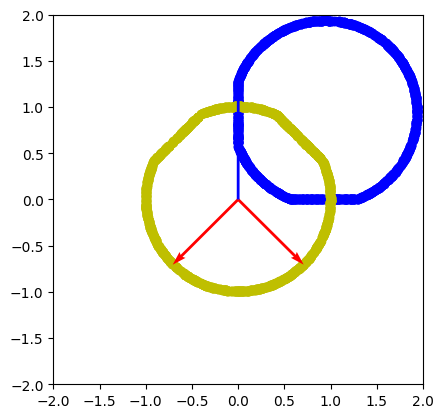

In [10]:
unit_circle_sae = SAE(2, 2)
# Paper uses sparsity penalty of 0.1, this did not work for me. Reconstruction resulted in two lines and a half-circle
# you should be seeing a loss of around 0.02, if it's much higher rerun the training
unit_circle_sae.train(unit_circle_points, sparsity_penalty=0.01, lr=1e-3)

unit_circle_points_acts, unit_circle_points_reconst = unit_circle_sae(mx.array(unit_circle_points))
plt.scatter(unit_circle_points_acts[:, 0], unit_circle_points_acts[:, 1], color="b")
plt.scatter(unit_circle_points_reconst[:, 0], unit_circle_points_reconst[:, 1], color="y")

unit_circle_sae.draw_dict_elements(plt)
plt.quiver(0, 0, unit_circle_sae.decoder.bias[0], unit_circle_sae.decoder.bias[1], angles='xy', scale_units='xy', scale=1, color='b')

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal')
plt.show()

Running the training code above you should get a loss of about 0.001. As expected the dictionary elements are two unit vectors that are perpendicular to each other. The SAE is fairly good are reconstructing the data.

#### Over-complete Case

In this next step we will train a SAE with more dictionary elements than strictly necessary. In this setup the loss will be higher because of the sparsity term in the loss function. However we should get a better reconstruction of the data. Also we will now get a set of dictionary elements that are no longer perpendicular.

Training: 100%|██████████| 20000/20000 [00:18<00:00, 1057.23iter/s, Loss=0.0128]


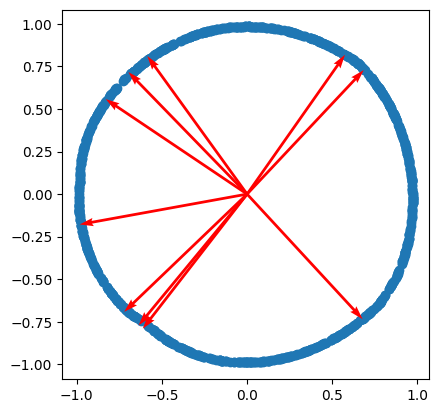

In [11]:
unit_circle_over_complete_sae = SAE(2, 10)
unit_circle_over_complete_sae.train(unit_circle_points, sparsity_penalty=0.1, lr=1e-4, max_iter=20000, batch_size=256)

unit_circle_points_over_complete_acts, unit_circle_points_over_complete_reconst = unit_circle_over_complete_sae(mx.array(unit_circle_points))
plt.scatter(unit_circle_points_over_complete_reconst[:, 0], unit_circle_points_over_complete_reconst[:, 1])
unit_circle_over_complete_sae.draw_dict_elements(plt)

plt.gca().set_aspect('equal')
plt.show()

The take-away from the above experiments is that when the SAE is capacity constrained it will learn a set of dictionary elements that are perpendicular to each other. Most of the time each dictionary element will be needed to represent a data point, as such most of the elments will be activated for each data point. It is most and not all because for a circle we have 4 points that can be represented by a single vector.

When the SAE has more capacity than necessary, a data point can be represented using a subset of the dictionary elements. In this case the dictionary elements are more similar to each other and the activations of the SAE on the data will be more sparse.

### Some open questions:
* In the complete case the activations consistently have two flat edges. Why is this?
* Why do the hyperparameters from the paper not reproduce?
* Why is are the activations shifted from the origin in the complete case, but not in the over-complete case?

## Multiple Circular Datasets

In the previous section we only had one dataset which was represented by two dimensions. In this next step we want to show how use a SAE to distinguish two such datasets in a higher dimensional space.

We generate two unit circles that we embed in a higher dimensional space (R^10 in this case). We then train a SAE on this data. Assuming that it represents the data well (spoiler: it will), the question is then how do we disentangle the two datasets based on the internal activations.

Ideally we will discover two disjoint sets of dictionary elements each one corresponding to one of the two circles. From the previous section we can expect to have one of two cases occurring:
1. the SAE is capacity constrained and we will have two sets of dictionary elements that are perpendicular to each other or
2. the SAE is over-complete and we will have two sets of dictionary elements where the elements have high angular similarity to each other

We now train setup a training data set that contains two unit circles that are embedded in the e1-e2 and e2-e3 planes respectively. Then we train an SAE with 64 dictionary elements. During the training we sample the two circles alternatingly such that the SAE will never see both circles at the same time.

In [12]:
def embed_random_points_on_unit_circle(N, M, dims):
    """
    Generate N random points on a unit circle embedded in an M-dimensional space.

    Parameters:
    N (int): Number of points to generate.
    M (int): Dimensionality of the space.
    dims (tuple): Indices of the dimensions in which the circle lies.

    Returns:
    np.ndarray: An array of shape (N, M) containing the random points.
    """
    angles = 2 * np.pi * np.random.rand(N)
    x = np.cos(angles)
    y = np.sin(angles)

    points = np.zeros((N, M))
    points[:, dims[0]] = x
    points[:, dims[1]] = y
    return points

unit_circle1_in_high_dimensions = embed_random_points_on_unit_circle(1000, 10, (0, 1))
unit_circle2_in_high_dimensions = embed_random_points_on_unit_circle(1000, 10, (2, 3))

high_dimensions_sae = SAE(10, 64)
high_dimensions_sae.train([unit_circle1_in_high_dimensions, unit_circle2_in_high_dimensions], sparsity_penalty=0.01, lr=1e-3, batch_size=128)

Training: 100%|██████████| 20000/20000 [00:19<00:00, 1031.13iter/s, Loss=0.0002]  


Let's look at the reconstruction by the SAE:

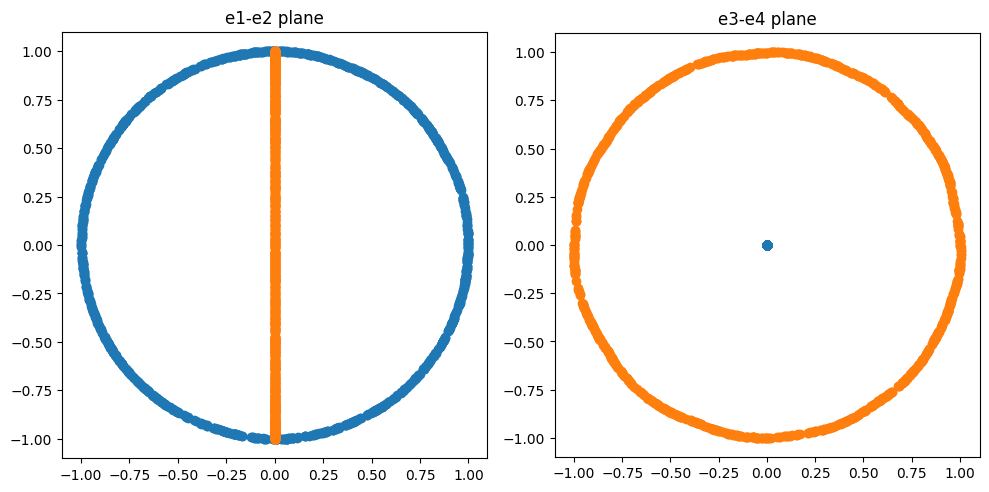

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

recon_unit_circle1_in_high_dimensions = high_dimensions_sae(mx.array(unit_circle1_in_high_dimensions))[1]
recon_unit_circle2_in_high_dimensions = high_dimensions_sae(mx.array(unit_circle2_in_high_dimensions))[1]

axs[0].scatter(recon_unit_circle1_in_high_dimensions[:, 0], recon_unit_circle1_in_high_dimensions[:, 1])
axs[0].scatter(recon_unit_circle2_in_high_dimensions[:, 0], recon_unit_circle1_in_high_dimensions[:, 1])
axs[0].set_aspect('equal')
axs[0].set_title('e1-e2 plane')

axs[1].scatter(recon_unit_circle1_in_high_dimensions[:, 2], recon_unit_circle1_in_high_dimensions[:, 3])
axs[1].scatter(recon_unit_circle2_in_high_dimensions[:, 2], recon_unit_circle2_in_high_dimensions[:, 3])
axs[1].set_aspect('equal')
axs[1].set_title('e3-e4 plane')

plt.tight_layout()
plt.show()

As our SAE has 64 dictionary elements it is highly overcomplete. As the training has a sparsity constraint some of these will not be used, they are dead. We can identify them by looking at the hidden activations on our dataset. We filter the list of hidden activations for any which have a mean activation larger than a very small value (1e-8). These are the alive dictionary elements.

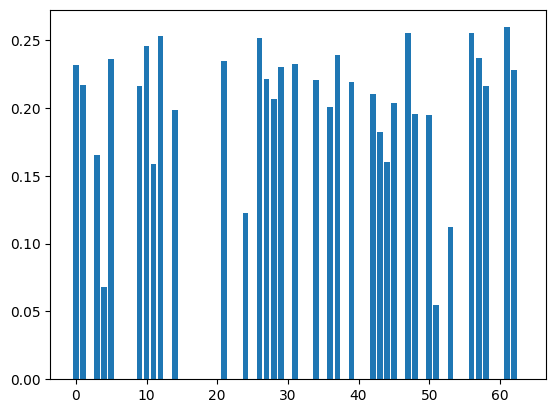

In [48]:
high_dimensions_activations = high_dimensions_sae(mx.concatenate([mx.array(unit_circle1_in_high_dimensions), mx.array(unit_circle2_in_high_dimensions)]))[0]
high_dimensions_alive_frac  = np.array(mx.mean(mx.abs(high_dimensions_activations) > 1e-8, axis=0))
high_dimensions_alive_idxs  = np.where(high_dimensions_alive_frac > 1e-8)[0]
plt.bar(np.arange(64), high_dimensions_alive_frac)
plt.show()

We start with a sanity check. The input data is aligned to two planes, therefore if we got a clean separation between the two datasets we should see two planes in the activations.

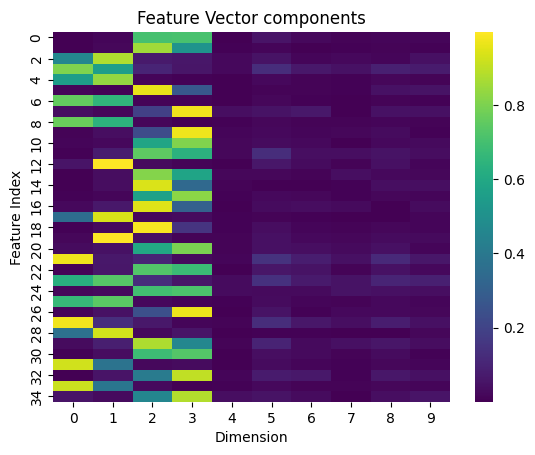

In [49]:
high_dimensions_sae_alive_dicts = np.array(high_dimensions_sae.decoder.weight)[:, high_dimensions_alive_idxs]
sns.heatmap(np.abs(high_dimensions_sae_alive_dicts.T), annot=False, cmap='viridis', linewidths=0)
plt.title('Feature Vector components')
plt.xlabel('Dimension')
plt.ylabel('Feature Index')
plt.show()

In the graph above we clearly see that the dictionary elements are mostly aligned with e1-e2 & e3-e4 basis vectors.

Now we proceed to cluster the elements. We will use spectral clustering, which takes as input a distance matrix with positive values. To calculate the distance matrix we will use cosine similarity which in our case is equivalent to the dot product as the dictionary elements are unit vectors. For the vectors which are in the same plane this will tend to return values close to 1 or -1. For vectors that are in different planes the value will be close to 0. As we need postive values we take the absolute value of the dot product and then convert it into an angle using `arccos`.

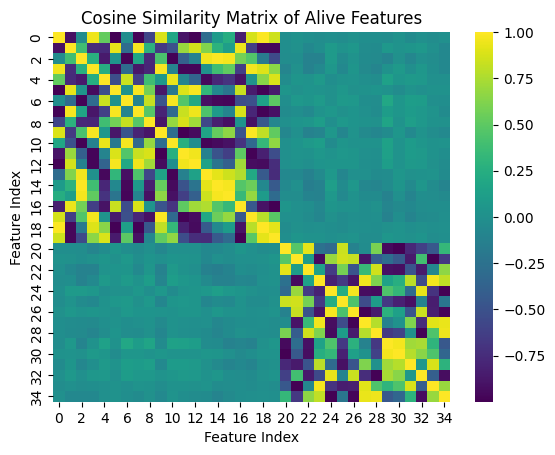

In [206]:
from sklearn.cluster import SpectralClustering

high_dimensions_cosine_similarity = np.dot(high_dimensions_sae_alive_dicts.T, high_dimensions_sae_alive_dicts)

spectral                       = SpectralClustering(n_clusters=2, affinity='precomputed')
high_dimensions_similarity     = 1 - np.arccos(np.abs(np.clip(high_dimensions_cosine_similarity, -1.0, 1.0)))/np.pi
high_dimensions_cluster_labels = spectral.fit_predict(high_dimensions_similarity)

high_dimension_zero_dict_idxs = high_dimensions_alive_idxs[high_dimensions_cluster_labels == 0]
high_dimension_one_dict_idxs  = high_dimensions_alive_idxs[high_dimensions_cluster_labels == 1]

sorted_indices = np.argsort(high_dimensions_cluster_labels)
sorted_sims    = high_dimensions_cosine_similarity[sorted_indices][:, sorted_indices]
sns.heatmap(sorted_sims, cmap='viridis', annot=False)
plt.title("Cosine Similarity Matrix of Alive Dictionary Elements")
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()

Using the clustering we now have two sets of vectors that correspond to the two datasets, ie the two unit circles of our input data. We now show that these clusters are sufficient to reconstruct the relevant part of the input data.

The approach is the following:
1. in activations we used to identify the alive dictionary elements, we now search for all samples that activate at least one of the elements in a cluster. We ignore any samples that activate no element.
2. for each activation, we set the hidden activations that are not in the cluster to zero
3. then reconstruct the input using the weights and bias from the decoder

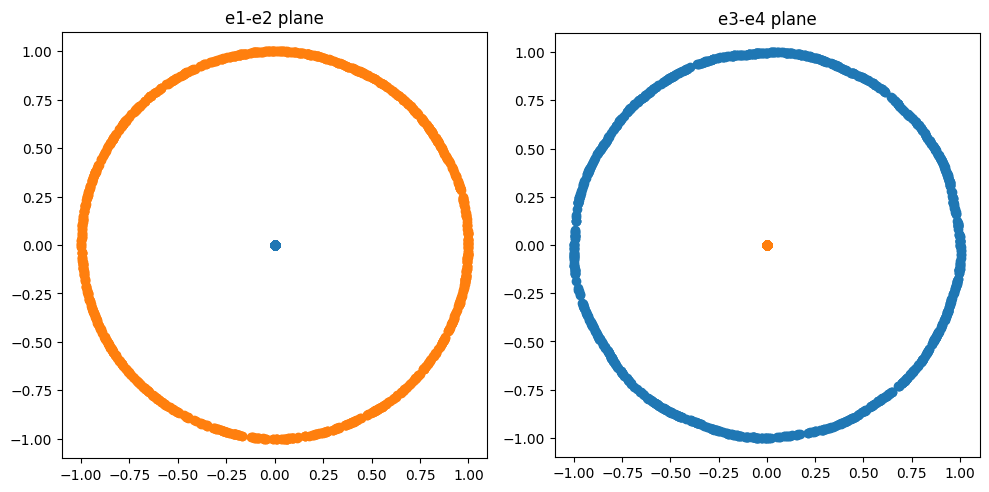

In [207]:
# find all the activations that activate at least one of the dictionary elements in each cluster, create a copy of the array
high_dimension_zero_samples_idxs = np.where(np.sum(np.array(high_dimensions_activations)[:, high_dimension_zero_dict_idxs], axis=1) > 0.01)[0]
high_dimension_one_samples_idxs  = np.where(np.sum(np.array(high_dimensions_activations)[:, high_dimension_one_dict_idxs], axis=1) > 0.01)[0]
high_dimension_zero_activations  = np.array(high_dimensions_activations)[high_dimension_zero_samples_idxs].copy()
high_dimension_one_activations   = np.array(high_dimensions_activations)[high_dimension_one_samples_idxs].copy()

# find the indices of all hidden activations not part of each cluster and set them to zero in the activations copy
high_dimension_not_zero_dict_idxs = np.setdiff1d(np.arange(high_dimensions_activations.shape[1]), high_dimension_zero_dict_idxs)
high_dimension_not_one_dict_idxs  = np.setdiff1d(np.arange(high_dimensions_activations.shape[1]), high_dimension_one_dict_idxs)
high_dimension_zero_activations[:, high_dimension_not_zero_dict_idxs] = 0
high_dimension_one_activations[:, high_dimension_not_one_dict_idxs]   = 0

# reconstruct & plot the samples
high_dimensions_zero_reconst = high_dimensions_sae.decoder(mx.array(high_dimension_zero_activations))
high_dimensions_one_reconst  = high_dimensions_sae.decoder(mx.array(high_dimension_one_activations))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(high_dimensions_zero_reconst[:, 0], high_dimensions_zero_reconst[:, 1])
axs[0].scatter(high_dimensions_one_reconst[:, 0], high_dimensions_one_reconst[:, 1])
axs[0].set_aspect('equal')
axs[0].set_title('e1-e2 plane')

axs[1].scatter(high_dimensions_zero_reconst[:, 2], high_dimensions_zero_reconst[:, 3])
axs[1].scatter(high_dimensions_one_reconst[:, 2], high_dimensions_one_reconst[:, 3])
axs[1].set_aspect('equal')
axs[1].set_title('e3-e4 plane')

plt.tight_layout()
plt.show()

Let's summarize what we learnt so far by applying the SAE's to the toy datasets:
1. An SAE can learn to reconstruct a dataset that is inherently two-dimensional.
2. For a SAE that is capacity constrained, the training will yield dictionary elements which are perpendicular. For a SAE with sufficient capacity we get some dead dictionary elements, that don't activate for any input. The alive elements will encode the data together. As they are not perpendicular they will have higher angular similarity
3. If we train the SAE on more than one dataset, where the data points of the different datasets never co-occur, the SAE will learn to disentangle the different datasets.
4. In this case the dictionary elements will have high angular similarity with amongst their set and low angular similarity between the sets.
5. Using spectral clustering we can identify the clusters of dictionary elements

In the following Theory section we will formalize these results.


# Theory

We are looking at the hidden activations of a transformer, also known as the residual stream. The transformer takes as input tokens denoted as $\vec{t} = (t_1, ..., t_n)$ where the token $t_i$ are taken from the vocabulary $V$ producing a sequence of hidden states $\vec{x_{i,l}}$ for each token $t_i$ at layer $l$ and a sequence of logit output $\vec{y_{i}}$.

One way to understand the structure of the hidden activations is the Linear Superposition Hypothesis. This hypothesis has be posited in previous works and the paper we are looking at is reformulating it. We will now restate the definitions as given in the paper with some additional notes. The main point of the Linear Superposition Hypothesis is that hidden activations can be decomposed into features that are independent of each other. Examples of such features might be the language of sentence or whether it is positive or negative.

Formally, we define a feature as a function $f(t) : V \rightarrow \mathbb{R}^n$ over the input tokens. The paper introduces the generalization to the multidimensional case of $\mathbb{R}^n$. Before stating the original hypothesis we introduce the concept of almost orthogonal vectors. A set $X$ of $\delta$-orthogonal vectors is one where $|\vec{x_1} \cdot \vec{x_2}| < \delta \quad \forall \vec{x_1}, \vec{x_2} \in X$, ie the dot product is smaller than some constant. The Linear Superposition Hypothesis (in the one-dimensional case) states that the hidden activations $x_{i,l}$ are the sum of many pairs of features $f_i$ and pair-wise $\delta$-orthogonal vectors $\vec{v_i}$ such that $\vec{x_{i,l}} = \sum_i f_i(t_i) \vec{v_i}$.

This definition aligns nicely with the capacity of SAE's to decompose its input into a vector of hidden activations along with the column vectors of the decoder ie the dictionary elements.

In the paper we this hypothesis is extended to the multidimensional case where the range of $f$ is $\mathbb{R}^n$. As we saw in our toy examples SAE can succesfully reconstruct data that is inherently two-dimensional. Using the ad-hoc clustering method we then grouped sets of dictionary elements the together encode the data. The SAE hidden activations associated with these dictionary elements now represent a multi-dimensional feature. The multidimensional version of the Superposition Hypothesis as introduced in the paper now states that hidden states of a LM are the sum of many pairs of features $\vec{f_i}$ and pair-wise $\delta$-orthogonal matrices $\mathbf{V_i}$ such that $\vec{x_{i,l}} = \sum_i \vec{f_i(t_i)} \mathbf{V_i}$. Two matrices $\mathbf{V_1}$ & $\mathbf{V_2}$ are $\delta$-orthogonal if $|\vec{x1} \cdot \vec{x2}| < \delta \quad \forall \vec{x_1} \in \mathbf{V_1}, \vec{x_2} \in \mathbf{V_2}$.

For the multidimensional features $\vec{f_i}$ to be meaningful the following statistical properties must be met:
1. any combination of two features $\vec{f_i}$ and $\vec{f_j}$ mutually independent on their shared domain, ie they must not be active at the same time
2. the features $\vec{f_i}$ must not be seperable, ie they cannot be decomposed into a linear combination of other features

In the paper the authors develop techniques to empirically verify these requirements on a trained SAE. But we will not repeat them in this tutorial.

Another interesting aspect is the impact of multi-dimensional features on the capacity of a language model. The Superposition Hypothesis was motivated by the observation that in neural networks individual neurons are often "polysemantic", meaning they activate for several unrelated concepts. The Superposition Hypothesis explains this phenomenon because encoding the meaning of a token in a superposition of $\delta$-orthogonal vectors vastly increases its capacity. In particular according to the Johnson-Lindenstrauss lemma, for an $n$-dimensional space there are only $n$ orthogonal vectors, but there are $exp(n)$ almost, $\delta$-orthogonal vectors.

The paper proves a Theorem there is an exponential reduction in the number of features that are representable as $\delta$-orthogonal matrices. This counteracts the exponential increase in capacity that the Superposition Hypothesis suggests in the one-dimensional case. As such we can expect to find multi-dimensional features in the hidden activations of a transformer, but they might not be very common.

# Clustering the SAEs in a LM

We now have theoretical reasons to believe in the existence of multi-dimensional features, but are they real? To find out we will in this section look at a real language model, Gemma 2 9B in particular. In the paper the authors investigated GPT-2, Mistral 7B and Llama 3 8B. We choose Gemma 2 for this investigation because Google released a full set of SAE weights under the name Gemma Scope [https://huggingface.co/google/gemma-scope]. This allows us to investigate many different layers of the model, without the computational expense of training the SAE's ourselves. Furthermore we can verify if the findings of the paper carry across to a different model.

As the real SAE's are much larger than our toy examples, we will be using a different clustering method. Rather than spectral clustering we implement a simple graph-based clustering method proposed in the paper.

In [1]:
def graph_clustering(layer, width, l0, cutoff, topk):
  def extract_adjacency():
    sae       = gemma2.JumpReLUSAE.load(layer=layer, width=width, l0=l0)
    all_sims  = sae.W_dec @ sae.W_dec.T       # all dictionary elements are normalized to unit length
    neigh_idx = np.argsort(all_sims, axis=1)[:, -1*(topk+1):-1]

    # construct the adjacency matrix for an undirected graph
    adjacency = np.zeros_like(all_sims)
    for i, row in enumerate(neigh_idx):
      adjacency[i, row] = 1
      adjacency[row, i] = 1
    # now remove all edges with similarity below the cutoff
    adjacency[all_sims < cutoff] = 0
    return adjacency

  def find_connected_components(adjacency):
    "Depth-first-search to find connected components in the graph"

    def dfs(node, adjacency, visited, component):
      stack = [node]
      while stack:
        node = stack.pop()
        if not visited[node]:
          visited[node] = True
          component.append(node)
          stack.extend([neighbor for neighbor in range(len(adjacency[node])) if adjacency[node][neighbor] == 1 and not visited[neighbor]])

    num_nodes  = len(adjacency)
    visited    = [False] * num_nodes
    components = []
    for node in tqdm(list(range(num_nodes))):
      if not visited[node]:
        component = []
        dfs(node, adjacency, visited, component)
        components.append(component)
    return components

  return [c for c in find_connected_components(extract_adjacency()) if len(c) > 2]

The above above clustering will give us sets of possibly related features. We however have no idea of what a cluster corresponds to. To understand the meaning of a cluster of dictionary elements we will have to manually inspect it using a visualization function that we implement below.

Before presenting the implementation we will discuss the intuition behind the visualization. First of all we are looking for simple concepts that can be represented by single words. The example we will be working with in the rest of the tutorial are weekdays and months. These can be considered to be arranged on a circle, as we will see later on. Fortunately weekdays are common enough that they are represented as individual tokens by the language model.

We will characterise a cluster of features by the tokens that most consistently and strongly activate it. To that end we will generate the feature activations on a large dataset. Then for each feature and token combination we calculate the mean activation and the standard deviation. If a token is strongly activating a feature it will have a high mean activation. If the concept captured by a feature is enapsulated in a single word then we expect the standard deviation of the activations to be low. On the other hand for concepts that are context dependent we would expect the activation associated with a particular token to vary a lot, depending on the surrounding tokens. As we are looking at single tokens, we cannot capture the context effects.

## Technical details of generating activations data

Generating these activations is computationally expensive. For this tutorial activation data was pre-calculated and made available on Huggingface (https://huggingface.co/datasets/derfred/multi_dimensional_features_tutorial). If you wish to regenerate the data you can use the scripts `prepare_activations.py` & `activation_stats.py` in this repository. The data for the rest of the tutorial was generated with the following parameters:
* About 47 million (256 * 4096 * 45) tokens from the dataset monology/pile-uncopyrighted with context length of 256
* Activations from Gemma 2 9b in 8bit quantization
* Hidden layer activations from the residual stream in layer 5
* The GemmaScope SAE's were used in particular with width 16k and L0 of 37
* Store only the top 64 activations for each token

The `prepare_activations.py` script will output a set of .npz files containing the feature activations. Each file contains the following numpy arrays:
* llm_tokens - shape (split_size, context_size) - the tokens that were used to generate the activations
* sae_idxs - shape (split_size, context_size, top_k_features) - the indices of the features that were activated
* sae_acts - shape (split_size, context_size, top_k_features) - the value of the activations of the features that were activated

The `activation_stats.py` script will analyse the activations and calculate the intermediate data to calcualate the standard deviation for a set of token-feature pairs. The output is a .pkl file containing the following Python arrays, that are each of length `num_features`:
* tok_idxs - for each of feature an array of tokens that activate it
* tok_acts - for each of feature an array of activations, which correspond to the tokens in tok_idxs
* tok_mns  - for each of feature an array of mean activations, which correspond to the tokens in tok_idxs
* tok_m2s  - for each of feature an array of M2 values, which correspond to the tokens in tok_idxs

The M2 values are the sum of the squared differences from the mean. They are an intermediate value in [Welford's Algorithm](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm)

In [8]:
def plot_cluster_activations(cluster, layer, width, l0, topk=50):
  from huggingface_hub import hf_hub_download

  fname = f"feature_token_stats_layer_{layer}_width_{width}_l0_{l0}.pkl"
  if not os.path.exists(f"cache/{fname}"):
     hf_hub_download(repo_id="derfred/multi_dimensional_features_tutorial", filename=fname, repo_type="dataset", local_dir="cache")

  with open(f"cache/{fname}", "rb") as f:
    tok_idxs, tok_cnts, tok_mns, tok_m2s = pickle.load(f)

  # reconstruct the part of the feature-token activation matrix relevant to this cluster
  feat_counts = np.zeros((len(cluster), 256128), dtype=np.int32)
  feat_means  = np.zeros((len(cluster), 256128), dtype=np.float32)
  feat_m2s    = np.zeros((len(cluster), 256128), dtype=np.float32)
  for i, feat in enumerate(cluster):
    feat_counts[i, tok_idxs[feat]] = tok_cnts[feat]
    feat_means[i, tok_idxs[feat]]  = tok_mns[feat]
    feat_m2s[i, tok_idxs[feat]]    = tok_m2s[feat]

  # calculate the mean and standard deviation using Welford's Algorithm https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm
  eps    = 1e-10
  counts = np.sum(feat_counts, axis=0)
  means  = np.sum(feat_counts * feat_means, axis=0) / (counts + eps)
  m2s    = np.sum(feat_m2s + feat_counts * (feat_means - means)**2, axis=0)
  stdevs = np.sqrt(m2s / (counts - 1 + eps))

  # plot the topk tokens with the highest mean activation for the features in the cluster
  # the shaded region represents the standard deviation
  # also output the detokenized strings as labels
  top_feat_idxs = np.argsort(means)[::-1]
  plt.figure(figsize=(10,6))
  plt.plot(means[top_feat_idxs][:topk])
  plt.fill_between(range(topk), (means - stdevs)[top_feat_idxs][:topk], (means + stdevs)[top_feat_idxs][:topk], color='b', alpha=0.1)

  for i, tok in enumerate(top_feat_idxs[:topk]):
      plt.annotate(tokenizer.decode([tok]), (i, means[top_feat_idxs][i]), 
                  xytext=(5, 5), textcoords='offset points', 
                  rotation=45, ha='left', va='bottom', fontsize=8)
  plt.show()

For the purpose of this tutorial we identified some features that are activated by weekdays. We will now visualize it using our `plot_cluster_activations` function:

100%|██████████| 16384/16384 [03:34<00:00, 76.55it/s]


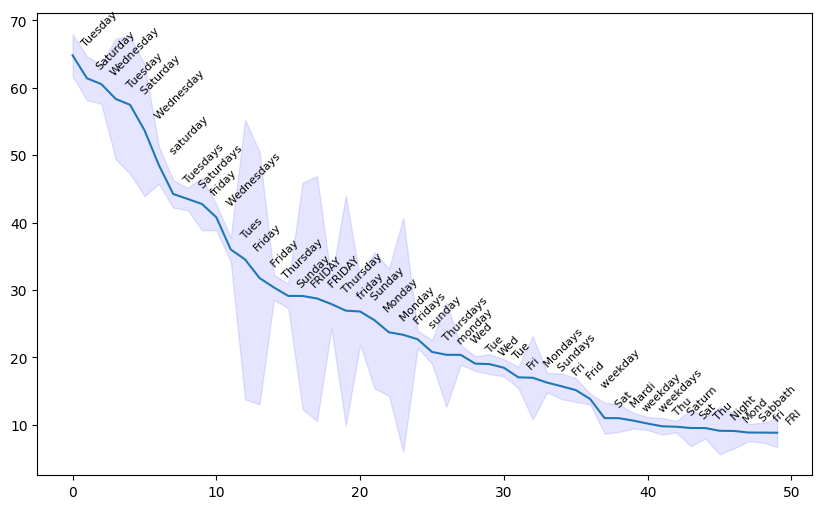

In [7]:
clusters_from_graph = graph_clustering(layer=5, width="16k", l0=37, cutoff=0.5, topk=2)
weekdays_cluster    = next(c for c in clusters_from_graph if len(set(c) & set([4203,  7881,  2350, 13120,  2188,  1004])) > 0)
plot_cluster_activations(weekdays_cluster, topk=50, layer=5, width="16k", l0=37)

In the above plot you see that the top 50 tokens by mean activation are the english names of the weekdays, along with some abbreviations like "Mon" and a few non-english weekday names like "Mardi". We also see that the standard deviation is generally quite low, indicating that the concept of a weekday is well captured by the feature.

* show that multiple dict elements are active at the same time
* histogram of the cluster sizes and percentage of coverage

### Excercises

Here are some exercises based on the content and data provided so far:

1. Use the `plot_cluster_activations` to find some more interesting clusters. Call it with the individual elements of the `clusters_from_graph` list. Can you visually identify what makes an "interesting" cluster?
2. Can you find a heuristic for identifying interesting clusters? Try to formalise the intuition behind the visualisation.
3. Implement a function to cluster based on Jaccard distance, instead of the cosine similarity. This will require a lot of computation. What other interesting clusters can you find?

# Circular Features in LMs

We have now shown that the weekdays are represented by a cluster of dictionary elements, that are activated in concert. We will now investigate the geometry of the representation of this concept in the residual stream of the Gemma 2 9B model. We will discover that the weekdays arranged in a circle. Having established the basic geometry of the representation we will then investigate how the representation is causually connected to the output of the model.

## Task

For this investigation we defined a task for the model to solve. We prompt the model to perform arithmetic over the weekdays (and months):

> Let's do some weekday math. Two days from saturday is ...

> Let's do some calendar math. Three months from January is ...

ie. we prompt the model to perform the modular addition (a + b) mod 7 = c and (a+b) mod 12 = c, where a & c are taken from the set of weekday or months respectively and b is an integer between 0 and 6, or 0 and 11. We call these tasks the weekday_task and month_task respectively.

To start we define some support code to make the handling of these prompts easier:

In [108]:
NUMBERS  = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine", "Ten", "Eleven", "Twelve"]
WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
MONTHS   = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def extract_residuals(fn):
  acts = []

  def hook(array, label=None):
    if label is not None and label.endswith("resid_post"):
      acts.append(np.array(array[:, fn.a_index]))
    return array

  tokens = mx.array([tokenizer.encode(prompt) for prompt in fn.prompts])
  model(tokens, hook=hook)
  return np.array(acts)

def promptfn(domain):
  def decorator(fn):
    fn.count         = len(domain)
    fn.domain        = domain
    fn.domain_tokens = [tokenizer.encode(i)[-1] for i in domain]
    assert [tokenizer.decode(i).strip() for i in fn.domain_tokens] == domain

    # next two variables encode the calendar math problems in the following order:
    # [(0, 0), (0, 1), ..., (0, count-1), (1, 0), ..., (1, count-1), ..., (count-1, count-1)]
    fn.a_values = np.hstack([np.array([i] * fn.count) for i in range(fn.count)])
    fn.offsets  = np.hstack([np.arange(fn.count) for _ in range(fn.count)])
    fn.c_values = (fn.a_values+fn.offsets) % fn.count
    fn.prompts  = [fn(a_token, offset) for a_token, offset in zip(fn.a_values, fn.offsets)]

    # find the index of the placeholder token
    fn.a_index = [tokenizer.decode(t).strip() for t in tokenizer.encode(fn(0, 1))].index(domain[0])

    return fn
  return decorator

@promptfn(WEEKDAYS)
def weekday_task(start, offset):
  suffix = "" if offset == 1 else "s"
  return f"Let's do some day of the week math. {NUMBERS[offset]} day{suffix} from {WEEKDAYS[start]} is"

@promptfn(MONTHS)
def month_task(start, offset):
  suffix = "" if offset == 1 else "s"
  return f"Let's do some calendar math. {NUMBERS[offset]} month{suffix} from {MONTHS[start]} is"

def model_output(prompts, logits=True):
  if isinstance(prompts, str):
    tokens = [tokenizer.encode(prompts)]
  else:
    tokens = [tokenizer.encode(prompt) for prompt in prompts]

  output = np.array(model(mx.array(tokens))[:, -1])
  if logits:
    return output
  else:
    return [tokenizer.decode(l) for l in np.argmax(output, axis=1)]

Let's have the model complete one problem from our task:

In [65]:
weekday_task(1, 2), model_output(weekday_task(1, 2), logits=False)

("Let's do some day of the week math. Two days from Tuesday is", ' Thursday')

In that first example the model successfully solved the problem. Let's evaluate it on the entire task:

In [85]:
def calendar_math_eval_and_show(fn):
  actual  = [s.strip() for s in model_output(fn.prompts, logits=False)]
  correct = [fn.domain[c] == a for c, a in zip(fn.c_values, actual)]
  output  = [f"{a} {'' if c else '*'}" for a, c in zip(actual, correct)]
  correct = np.array(correct).reshape(fn.count, -1)

  df = pd.DataFrame(np.array(output).reshape(fn.count, -1))
  def highlight_cells(val):
    return np.where(correct, "", 'background-color: orange; color: black')
  print(f"Correct: {np.sum(correct)}/{correct.shape[0]*correct.shape[1]} {round(np.sum(correct)/float(correct.shape[0]*correct.shape[1])*100, 2)}%")
  return df.style.apply(highlight_cells, axis=None)

In [86]:
calendar_math_eval_and_show(weekday_task)

Correct: 30/49 61.22%


,0,1,2,3,4,5,6
0,Monday,Tuesday,Wednesday,Thursday,Friday,Friday *,Saturday *
1,Tuesday,Wednesday,Thursday,Friday,Saturday,Saturday *,Saturday *
2,Wednesday,Thursday,Friday,Saturday,Saturday *,Sunday *,Tuesday
3,Thursday,Friday,Saturday,Sunday,Sunday *,Monday *,Tuesday *
4,Friday,Saturday,Sunday,Tuesday *,Tuesday,Tuesday *,Tuesday *
5,Saturday,Sunday,Tuesday *,Wednesday *,Wednesday,Wednesday *,Wednesday *
6,Sunday,Monday,Tuesday,Wednesday,Wednesday *,Thursday *,Wednesday *


In [87]:
calendar_math_eval_and_show(month_task)

Correct: 144/144 100.0%


,0,1,2,3,4,5,6,7,8,9,10,11
0,January,February,March,April,May,June,July,August,September,October,November,December
1,February,March,April,May,June,July,August,September,October,November,December,January
2,March,April,May,June,July,August,September,October,November,December,January,February
3,April,May,June,July,August,September,October,November,December,January,February,March
4,May,June,July,August,September,October,November,December,January,February,March,April
5,June,July,August,September,October,November,December,January,February,March,April,May
6,July,August,September,October,November,December,January,February,March,April,May,June
7,August,September,October,November,December,January,February,March,April,May,June,July
8,September,October,November,December,January,February,March,April,May,June,July,August
9,October,November,December,January,February,March,April,May,June,July,August,September


So the model does reasonably well on the Week task and does perfectly on the Month task

## Circular Representation of Weekdays & Months

We now investigate the represenation of the weekdays and months in the language model. The residual stream is illustrated in the diagram below. After the tokens have been turned into vectors by the embedding layer they are passed through a series of transformer blocks. For the rest of the tutorial we will be extracting and inject values at the Patch Points for a particular transformer block. 

```mermaid
  graph TD
    Input[Input Tokens] --> Embed[Token Embeddings]
    Embed --> RS1[Residual Stream]
    
    subgraph TB["Transformer Block (repeated N times)"]
        RS1 --> A[Attention Layer]
        A --> PALN[Layer Norm]
        RS1 --> PALN
        PALN --> FF[Feed Forward Layer]
        FF --> PFLN[Layer Norm]
        PALN --> PFLN
        PFLN --> HOOK[Patch Point]
    end
    
    HOOK --> Output[Output Logits]
    
    style HOOK fill:#f9f,stroke:#333,stroke-width:2px
    style TB fill:#e6f3ff,stroke:#333,stroke-width:2px
```

The first visualisation extracts the residual stream at a subset of blocks and applies PCA separately at each over the set of problems for each task. Below we plot the top 2 components.

In [92]:
def plot_residual_stream_pcas(promptfn, number_of_layers=None):
  residual_stream = extract_residuals(promptfn)

  layers   = np.linspace(0, model.num_hidden_layers-1, number_of_layers or model.num_hidden_layers, dtype=int)
  num_rows = math.ceil(len(layers) / 3)
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

  for i, ax in zip(layers, axs.flatten()):
    pca_acts = PCA(n_components=2).fit_transform(residual_stream[:, i]).reshape(promptfn.count, promptfn.count, 2)
    for j in range(promptfn.count):
      ax.scatter(pca_acts[j, :, 0], pca_acts[j, :, 1])
    ax.set_title(f"Layer {i}")

  plt.tight_layout()
  plt.show()

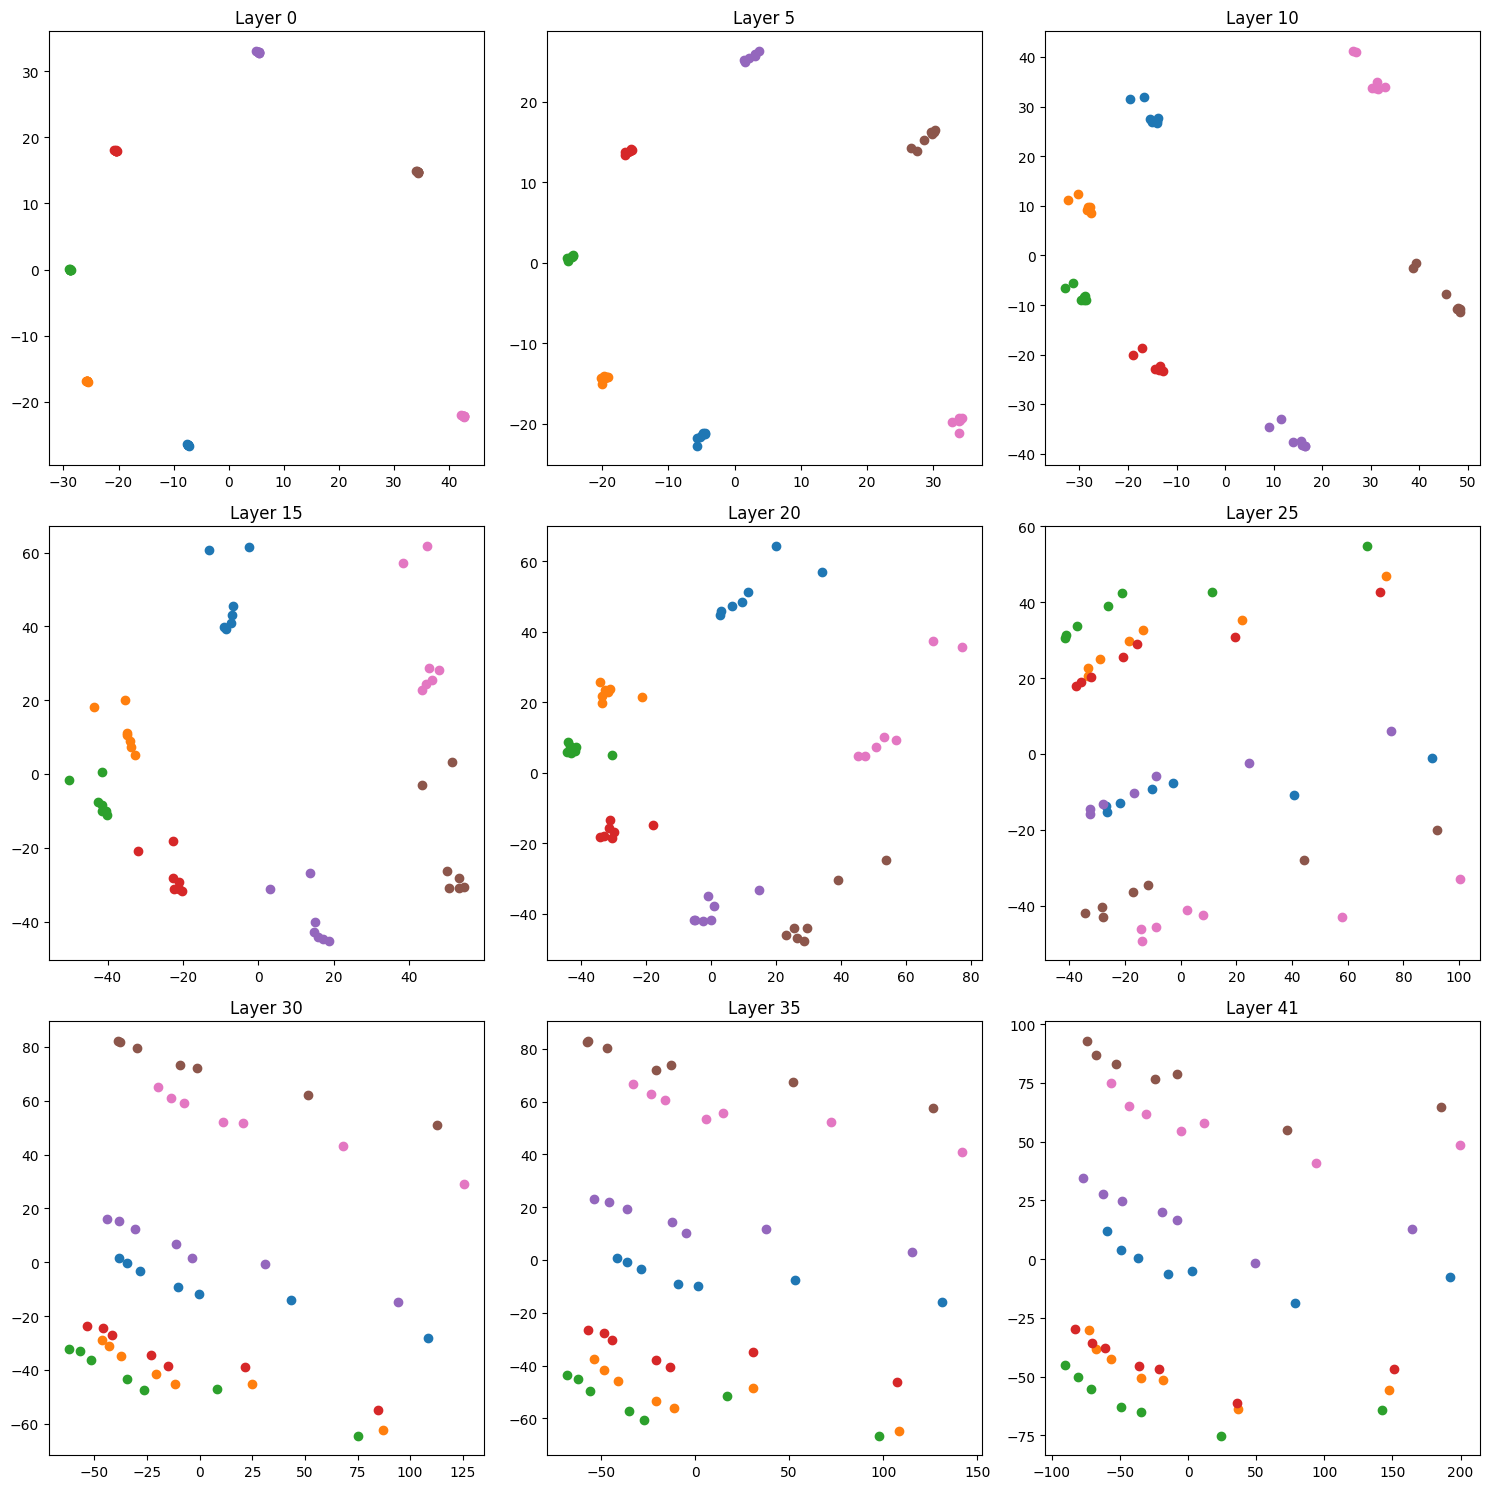

In [113]:
plot_residual_stream_pcas(weekday_task, number_of_layers=9)

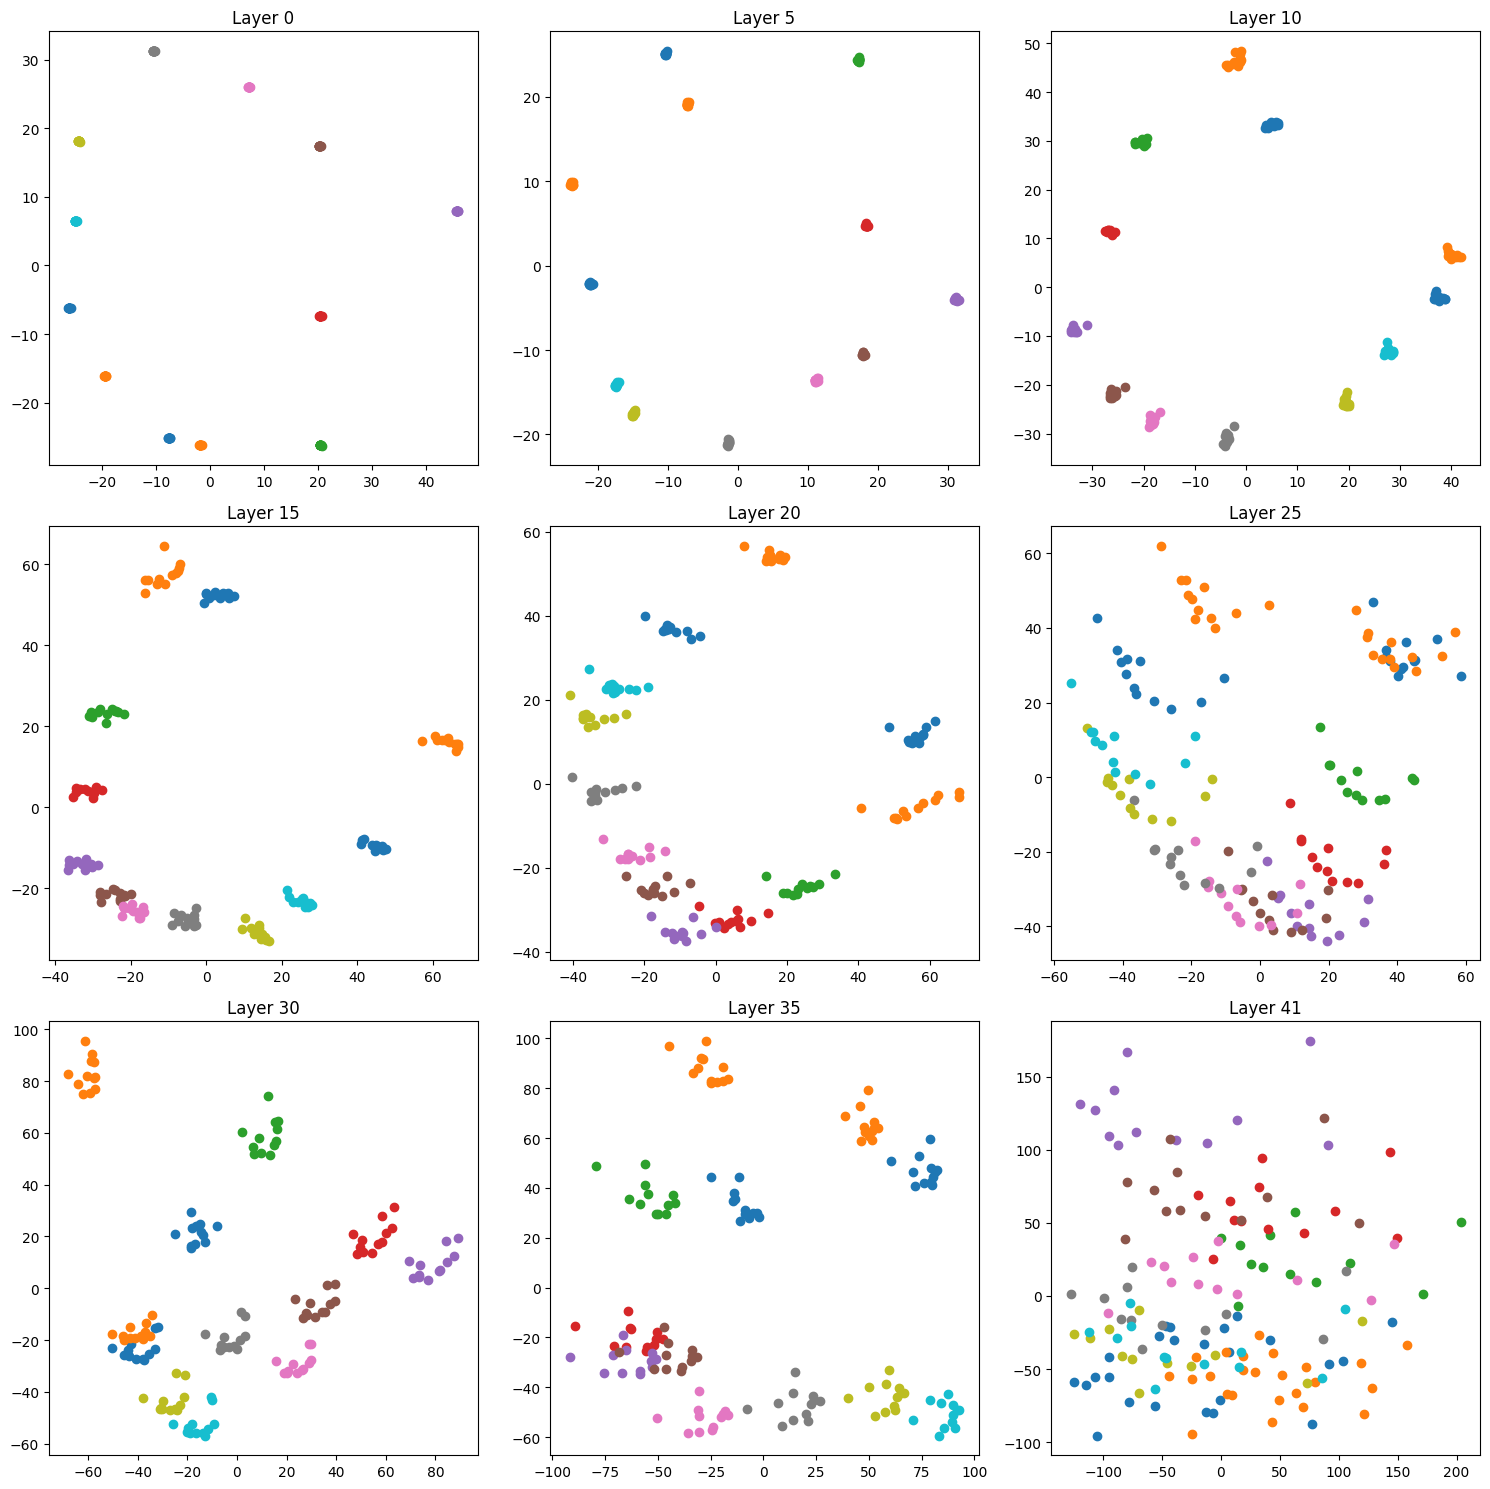

In [64]:
plot_residual_stream_pcas(month_task, number_of_layers=9)

We clearly see the circular arrangement of weekdays and months in the early layers of the model. For the weekdays this is transformed into a linear arrangement in about layer 20. For the months the circular arrangement seems to persist much deeper into the model.

# Intervention on Circular Features with Activation Patching experiments

To show whether the circular representation is causually connected to the output token of the model we now intervene in the residual stream of the model. This method is called activation patching. We will intervene on the residual stream of the model and measure the impact of the intervention on the output token. For this we will use the terminology "clean" and "dirty". If we take the residual stream the model produces for one particular prompt and inject it into the model for a different prompt we call the source "clean" as it is unmodified and the target "dirty". This naming carries across if the values injected into a model execution are generated by a different method like linear regression or PCA.

We also use the naming of "clean" and "dirty" to describe the input and output produced during a particular intervention. For example if we take the prompt "Two days from Tuesday is ..." with the result "Thursday" and modify the residual stream with the values associated with the prompt "Four days from Monday", then we have:

| Variable | Clean  | Dirty  |
|----------|-------------|-------------|
| α        | Monday      | Tuesday     |
| β        | Four        | Two         |
| γ        | Friday      | Thursday    |

For our patching experiments we setup a canonical ordering for the problems, which in the weekday task looks as follows:

| α        | β        | γ        |
|----------|----------|----------|
| Monday   | Zero     | Monday   |
| Monday   | One      | Tuesday  |
| Monday   | Two      | Wednesday|
| ...      | ...      | ...      |
| Monday   | Six      | Sunday   |
| Tuesday  | Zero     | Tuesday  |
| ...      | ...      | ...      |
| Sunday   | Six      | Saturday |

As we are looking at the representation of the weekday (and month) tokens in the residual stream we will only intervene on the α and variable. In the set of experiments below we replace each value by all of the other values, which gives us 6 * 49 = 294 and 11 * 144 = 1584 interventions for the weekday and month tasks respectively. The interventions are ordered such that we replace the α value by all possible values. In particular:

| α        | β        | γ        | α'       | β'       | γ'        |
|----------|----------|----------|----------|----------|-----------|
| Monday   | Zero     | Monday   | Tuesday  | Zero     | Tuesday   |
| Monday   | Zero     | Monday   | Wednesday| Zero     | Wednesday |
| ...      | ...      | ...      | ...      | ...      | ...       |
| Monday   | Zero     | Monday   | Sunday   | Zero     | Sunday    |
| Monday   | One      | Tuesday  | Tuesday  | One      | Wednesday |
| ...      | ...      | ...      | ...      | ...      | ...       |

In order to evaluate the impact of a particular intervention we define a metric. We calculate the logit difference between the logits for the clean and the dirty token. In the unmodified (clean) run the logit difference should be positive, ie the output for the clean token which represents the correct answer should be higher than for any other including the dirty token. If the intervention has the desired effect the difference will flip sign as the dirty token will now be more likely than the clean token.

Note this metric only captures a necessary but not a sufficient condition for the intervention to cause the desired effect. It might be that the output for a different token is even higher than for the dirty token.

We now introduce two helper functions to implement the intervention experiments. The `patching_params` sets up the outputs and the indices according to the canonical ordering described above. The `patching_experiment` function then runs the intervention experiments. It takes the `promptfn` function which gives the prompt for a particular task and also an `actsfn` that gives the residuals for each of the problem in a task. The output is the average logit difference for each of the interventions, and confidence intervals.

In [238]:
def patching_params(promptfn):
  """
    Setup the indices for the activation patching. Returns:
      * dirty_c: index of the GAMMA (output) token in the DOMAIN of promptfn, of the dirty (unpatched) problem
      * clean_c: index of the GAMMA (output) token in the DOMAIN of promptfn, of the clean (patching) variant of the problem
      * dirty_i: index of the dirty (unpatched) variant of the problem in the problem set
      * clean_i: index of the clean (patching) variant of the problem in the problem set
  """
  # the these transformations define the order in which we do the token interventions.
  # in short we replace each of the original $count problems with the $count-1 variations in-place
  dirty_c = np.repeat(promptfn.c_values, promptfn.count-1)
  clean_a = np.repeat([np.setdiff1d(np.arange(promptfn.count), [i]) for i in range(promptfn.count)], promptfn.count, axis=0).reshape(-1)
  clean_b = np.repeat(promptfn.offsets, promptfn.count-1)
  clean_c = (clean_a+clean_b) % promptfn.count
  dirty_i = np.repeat(np.arange(promptfn.count * promptfn.count), promptfn.count-1)
  clean_i = (clean_a*promptfn.count)+clean_b

  return dirty_c, clean_c, dirty_i, clean_i

def patching_experiment(promptfn, actsfn, layers=None, confidence=0.96):
  def replacement_hook_fn(layer, acts):
    def hook(array, label=None):
      if label == f"blocks.{layer}.hook_resid_post":
        array[:, promptfn.a_index] = acts
      return array
    return hook

  def patch_output(prompt, acts, layer):
    hook   = replacement_hook_fn(layer, acts)
    tokens = mx.array(tokenizer.encode(prompt))[None]
    return model(tokens, hook=hook)[0, -1, promptfn.domain_tokens]

  dirty_c, clean_c, _, _ = patching_params(promptfn)

  residuals = extract_residuals(promptfn)
  results   = []
  for layer in tqdm(layers or range(model.num_hidden_layers)):
    acts = actsfn(promptfn, residuals[layer])

    # two cases: 
    # 1. we have the same number of activation patches as problems. this happens if the activation patch does not depend on the \beta token.
    #    ie no-ops or average across all tasks. then we only need to evaluate each prompt from problem set once
    # 2. we have $count * ($count-1) activation patches, ie for each prompt in the problem set we evaluate the prompt with the 
    #    activation patch that corresponds to the clean \beta token
    prompts = promptfn.prompts if len(acts) == len(promptfn.prompts) else np.repeat(promptfn.prompts, promptfn.count-1)

    outputs = np.array([patch_output(p, a, layer) for p, a in zip(prompts, acts)])
    outputs = np.repeat(outputs, promptfn.count-1, axis=0) if len(acts) == len(promptfn.prompts) else outputs

    dirty_logits = outputs[np.arange(outputs.shape[0]), dirty_c]
    clean_logits = outputs[np.arange(outputs.shape[0]), clean_c]
    deltas       = dirty_logits - clean_logits

    mean, std_err = np.mean(deltas), scipy.stats.sem(deltas)
    band          = std_err * scipy.stats.t.ppf((1 + confidence) / 2.0, len(deltas) - 1)
    results.append([mean-band, mean, mean+band])
  return np.array(results)

We begin by establishing a baseline of no intervention. We will use the outputs as reference in the plots below.

In [110]:
def noop(promptfn, residuals):
  return residuals

weekday_noop = patching_experiment(weekday_task, noop)
month_noop   = patching_experiment(month_task, noop)

100%|██████████| 42/42 [04:04<00:00,  5.82s/it]


Finally a helper function for plotting the output of the patching experiments.

In [263]:
def intervention_plot(weekday_datas, month_datas):
  """
    Do a comparison plot between the no-op baseline and one or more intervention outcomes
  """
  weekday_datas = [(None, weekday_datas)]  if not isinstance(weekday_datas, list) else weekday_datas
  month_datas   = [(None, month_datas)] if not isinstance(month_datas, list) else month_datas

  all_layers = np.arange(model.num_hidden_layers)

  fig, axs   = plt.subplots(1, 2, figsize=(10, 5))
  any_labels = False  
  axs[0].set_title('Week')
  axs[0].plot(weekday_noop[:, 1])
  axs[0].fill_between(all_layers, weekday_noop[:, 0], weekday_noop[:, 2], alpha=0.5, label="No-op")

  for label, data in weekday_datas:
    axs[0].plot(data[:, 1])
    axs[0].fill_between(all_layers, data[:, 0], data[:, 2], alpha=0.5, label=label)
    any_labels = any_labels or (label is not None)

  if any_labels:
    axs[0].legend()

  any_labels = False
  axs[1].set_title('Month')
  axs[1].plot(month_noop[:, 1])
  axs[1].fill_between(all_layers, month_noop[:, 0], month_noop[:, 2], alpha=0.5, label="No-op")

  for label, data in month_datas:
    axs[1].plot(data[:, 1])
    axs[1].fill_between(all_layers, data[:, 0], data[:, 2], alpha=0.5, label=label)
    any_labels = any_labels or (label is not None)

  if any_labels:
    axs[1].legend()

  plt.show()

### Replace the with average across the task

We start with the simplest intervention. In the setup for this section we calculated the average activations for each layer across all instances of the problem.

In [8]:
def average_across_task(promptfn, residuals):
  return np.repeat([np.mean(residuals, axis=0)], len(promptfn.prompts), axis=0)

# This takes 15mins on my machine
weekday_average_replace = patching_experiment(weekday_task, average_across_task)
month_average_replace   = patching_experiment(month_task, average_across_task)

100%|██████████| 42/42 [10:38<00:00, 15.20s/it]


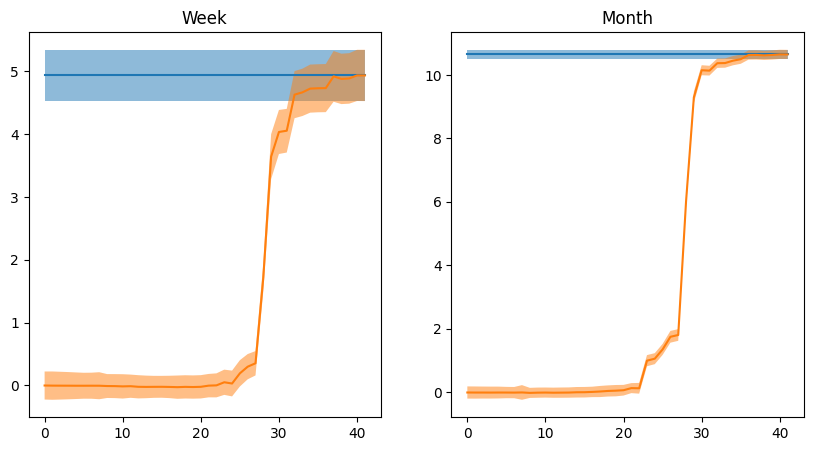

In [127]:
intervention_plot(weekday_average_replace, month_average_replace)

On its own the above graph does not tell us much yet. We might hypothesize that the calculation of the output happens some where between layer 20 and 30, based on the sharp decrease in impact of the intervention.

### Replace the entire layer

We now do the most extreme intervention. We replace the entire residual stream of a layer with the average residual stream of the layer. This will form the opposite end of the no-op baseline.

In [9]:
def replace_entire_layer(promptfn, residuals):
  return residuals[patching_params(promptfn)[3]]

# this takes about an hour on my machine
weekday_full_replace = patching_experiment(weekday_task, replace_entire_layer)
month_full_replace   = patching_experiment(month_task, replace_entire_layer)  ## check this again. the result is odd

100%|██████████| 42/42 [2:07:28<00:00, 182.11s/it]


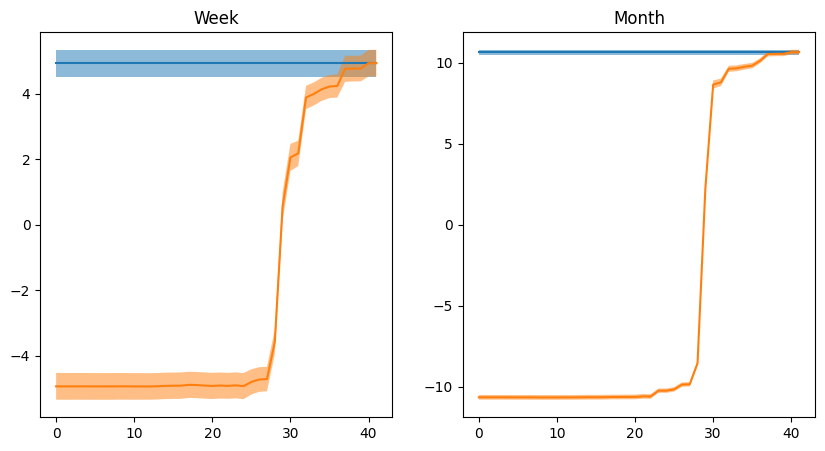

In [120]:
intervention_plot(weekday_full_replace, month_full_replace)

We now see a much bigger effect of the intervention. In particular switching out the complete layer almost exactly switches the sign of the logit difference.

### Replace with PCA(k=5) space

We now do a more "surgical" intervention on the residual stream. For each layer we perform a PCA for the top 5 components. This gives us a 5 dimensional subspace in the 3584 dimensional space of the residual stream. This subspace is what we will extract from the clean version.

The PCA gives us 5 vectors in the residual space. We calculate the projection of the clean and dirty residuals onto subspace spanned by the PCA vectors. We then add the clean projection and subtract the dirty projection. This in effect replaces the information that is contained in the PCA(k=5) subspace.

In [10]:
def pca_subspace_replace(promptfn, residuals):
  pca = PCA(n_components=5).fit(residuals)
  vec = np.dot(pca.transform(residuals), pca.components_)
  
  _, _, dirty_i, clean_i = patching_params(promptfn)
  return residuals[dirty_i] + vec[clean_i] - vec[dirty_i]

weekday_pca_replace = patching_experiment(weekday_task, pca_subspace_replace)
month_pca_replace   = patching_experiment(month_task, pca_subspace_replace)

100%|██████████| 42/42 [2:07:43<00:00, 182.46s/it]  


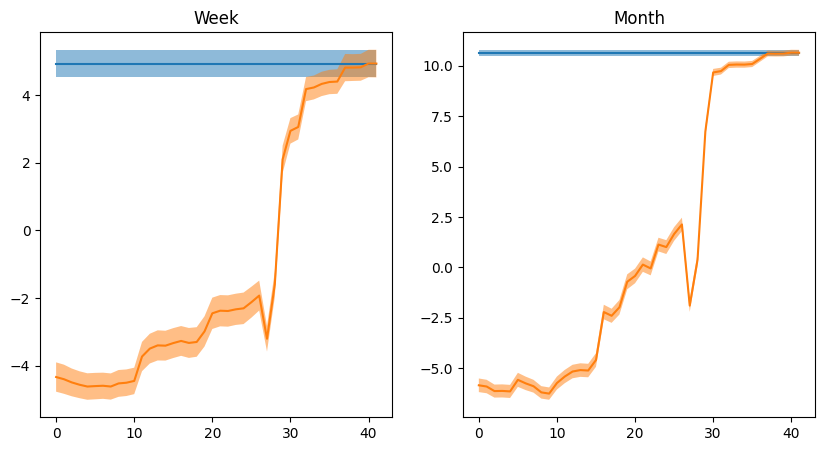

In [124]:
intervention_plot(weekday_pca_replace, month_pca_replace)

We now see a strong intervention effect that is a bit less strong than the complete replacement but stronger than the average replacement baseline.

### Replace with projection from circle

Finally the most interesting intervention. In the section "Circular Representation of Weekdays & Months" we saw that the weekday and month token in the residual stream are represented in a circular fashion. But we do not know if this representation is causally connected to the output token. In the previous experiments we saw that the PCA(k=5) subspace contains the information that determines a large part of the output token. We will now try to identify a circular part of the PCA(k=5) subspace which determines the output token to a similar degree as the PCA(k=5) subspace.

We will do so in two steps: First we extract the PCA(k=5) subspace from the residual stream. We then will train a projection matrix from that 5 dimensional space to a 2 dimensional space which contains equally spaced points on the unit circle. The following diagram illustrates the process:

![Linear Probe Training](linear_probe_training.svg)

The training of the project matrix is done using the Least Squares method (https://en.wikipedia.org/wiki/Least_squares)

In [132]:
def train_linear_probe(promptfn, residual):
  act = PCA(n_components=5).fit_transform(residual)

  # setup $count (= cardinality of the promptfn domain) number of points equally distributed on the unit circle
  w      = 2 * np.pi / promptfn.count
  circle = np.array([np.cos(w * promptfn.a_values), np.sin(w * promptfn.a_values)]).T

  # find the best fit of the PCA components to the circle, the arg min in equation 5
  return np.linalg.lstsq(act, circle, rcond=None)[0]

def train_linear_probes(promptfn, layers=None):
  # extract the residual streams and apply PCA to them, shape (layer, problem, hidden_dimension)
  residuals = extract_residuals(promptfn)
  layers    = layers if layers is not None else range(model.num_hidden_layers)
  return np.array([train_linear_probe(promptfn, residuals[i]) for i in layers])

As the circle is a 2 dimensional object we can easily visualise the result of training the linear probe. We transform the residuals into the PCA(k=5) subspace and then do a matrix multiplcation with the projection matrix. The result is a 2 dimensional vector that we can plot. By grouping the results by the clean token we can see how the circle is represented in the residual stream.

In [ ]:
def visualize_linear_probes(promptfn, number_of_layers=None):
  layers    = np.linspace(0, model.num_hidden_layers-1, number_of_layers or model.num_hidden_layers, dtype=int)
  residuals = extract_residuals(promptfn)

  w      = 2 * np.pi / promptfn.count
  circle = np.array([np.cos(w * np.arange(promptfn.count)), np.sin(w * np.arange(promptfn.count))])

  num_rows = math.ceil(len(layers) / 3)
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

  for i, (layer, ax) in enumerate(zip(layers, axs.flatten())):
    ax.set_title(f"Layer {layer}")

    # draw the big transparent dots for the ideal circle
    ax.scatter(circle[0], circle[1], s=1000, alpha=0.1)

    # apply PCA to this layers residuls, then group by each alpha token
    # ie. (Monday, 0), (Monday, 1), ..., (Monday, 6), (Tuesday, 0), ..., (Tuesday, 6), ..., (Sunday, 6)
    # then project each grouping into the circle space using the trained probe
    pca_acts = PCA(n_components=5).fit_transform(residuals[layer])
    pca_acts = pca_acts.reshape(promptfn.count, promptfn.count, -1)

    # an example of how to use the linear probe to project into the circle space
    probe     = train_linear_probe(promptfn, residuals[layer])
    proj_acts = pca_acts @ probe
    for j in range(promptfn.count):
      ax.scatter(proj_acts[j, :, 0], proj_acts[j, :, 1])

  plt.tight_layout()
  plt.show()

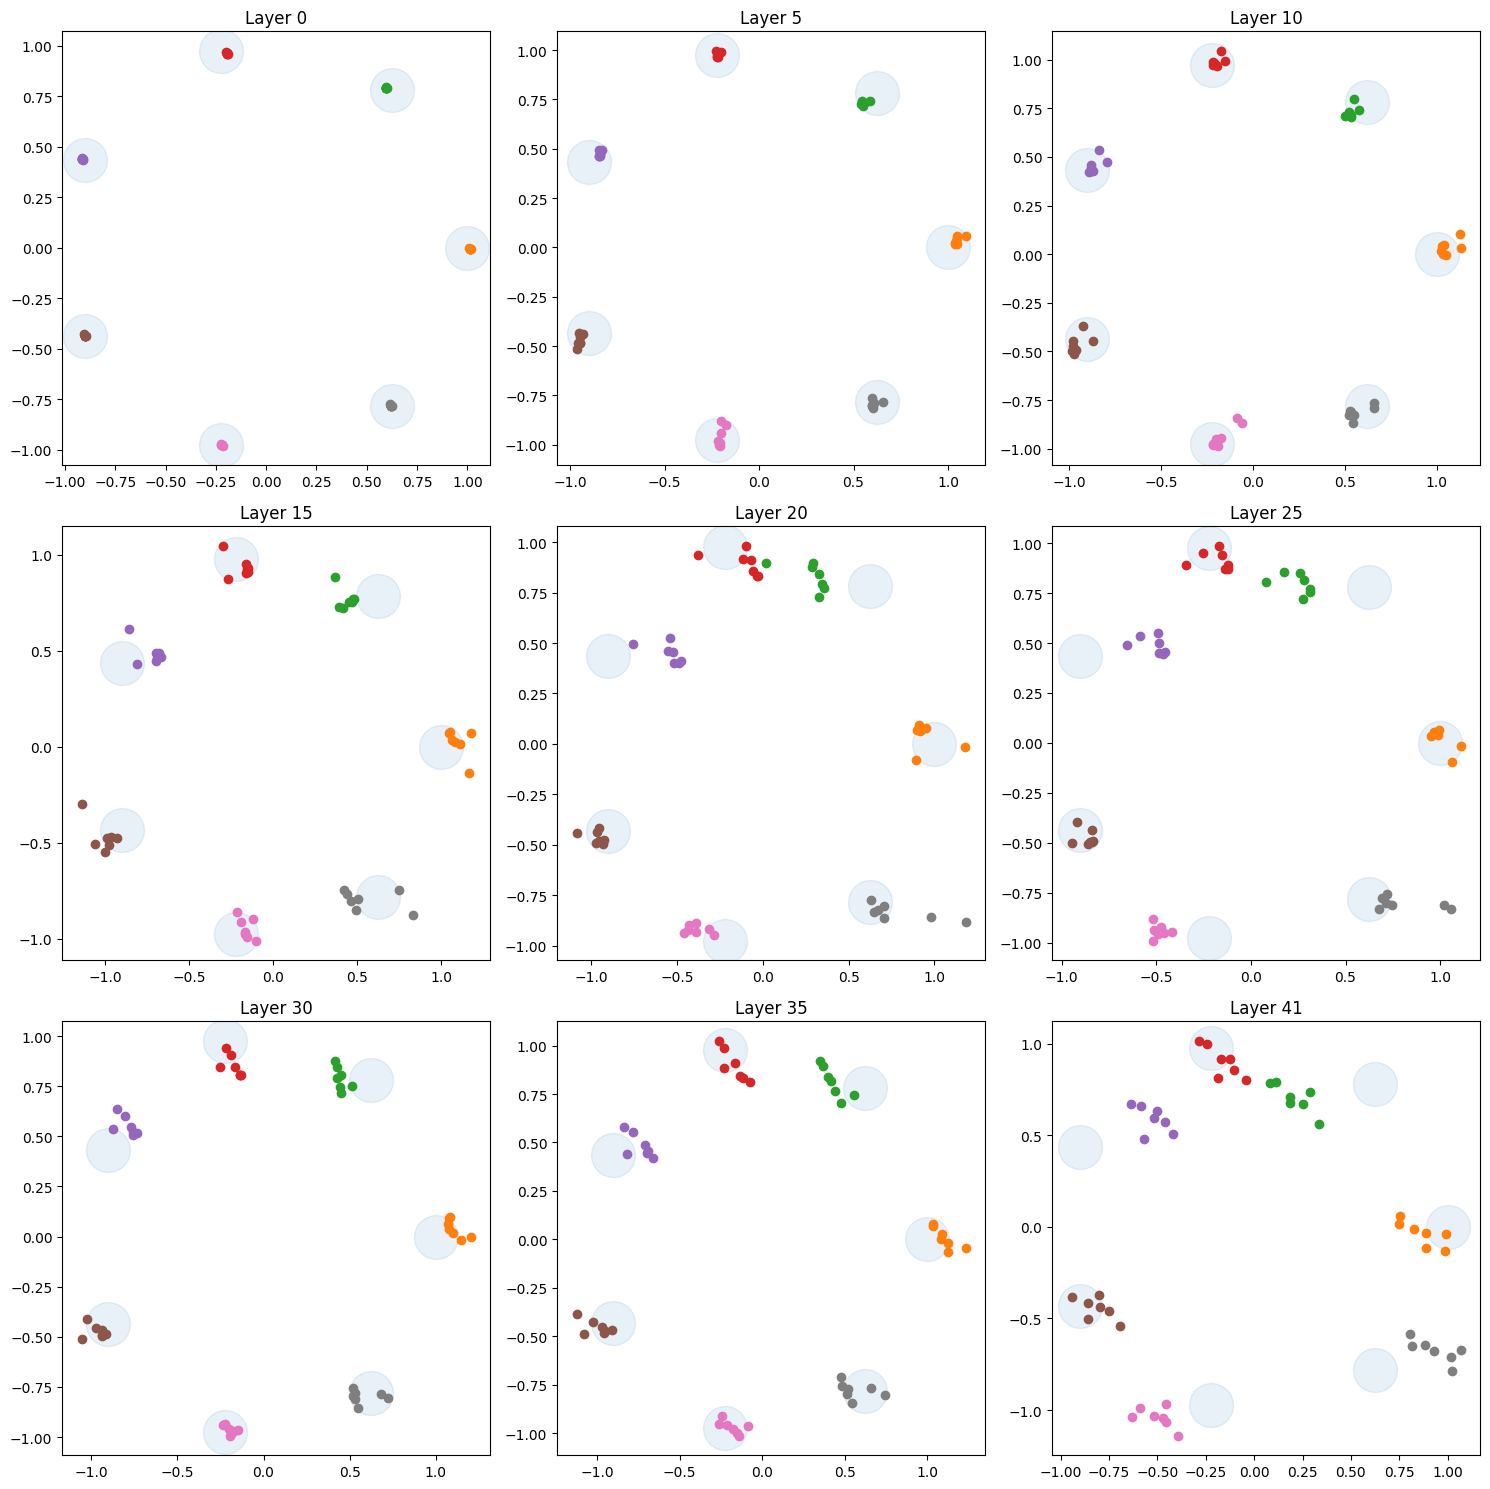

In [ ]:
visualize_linear_probes(weekday_task, 9)

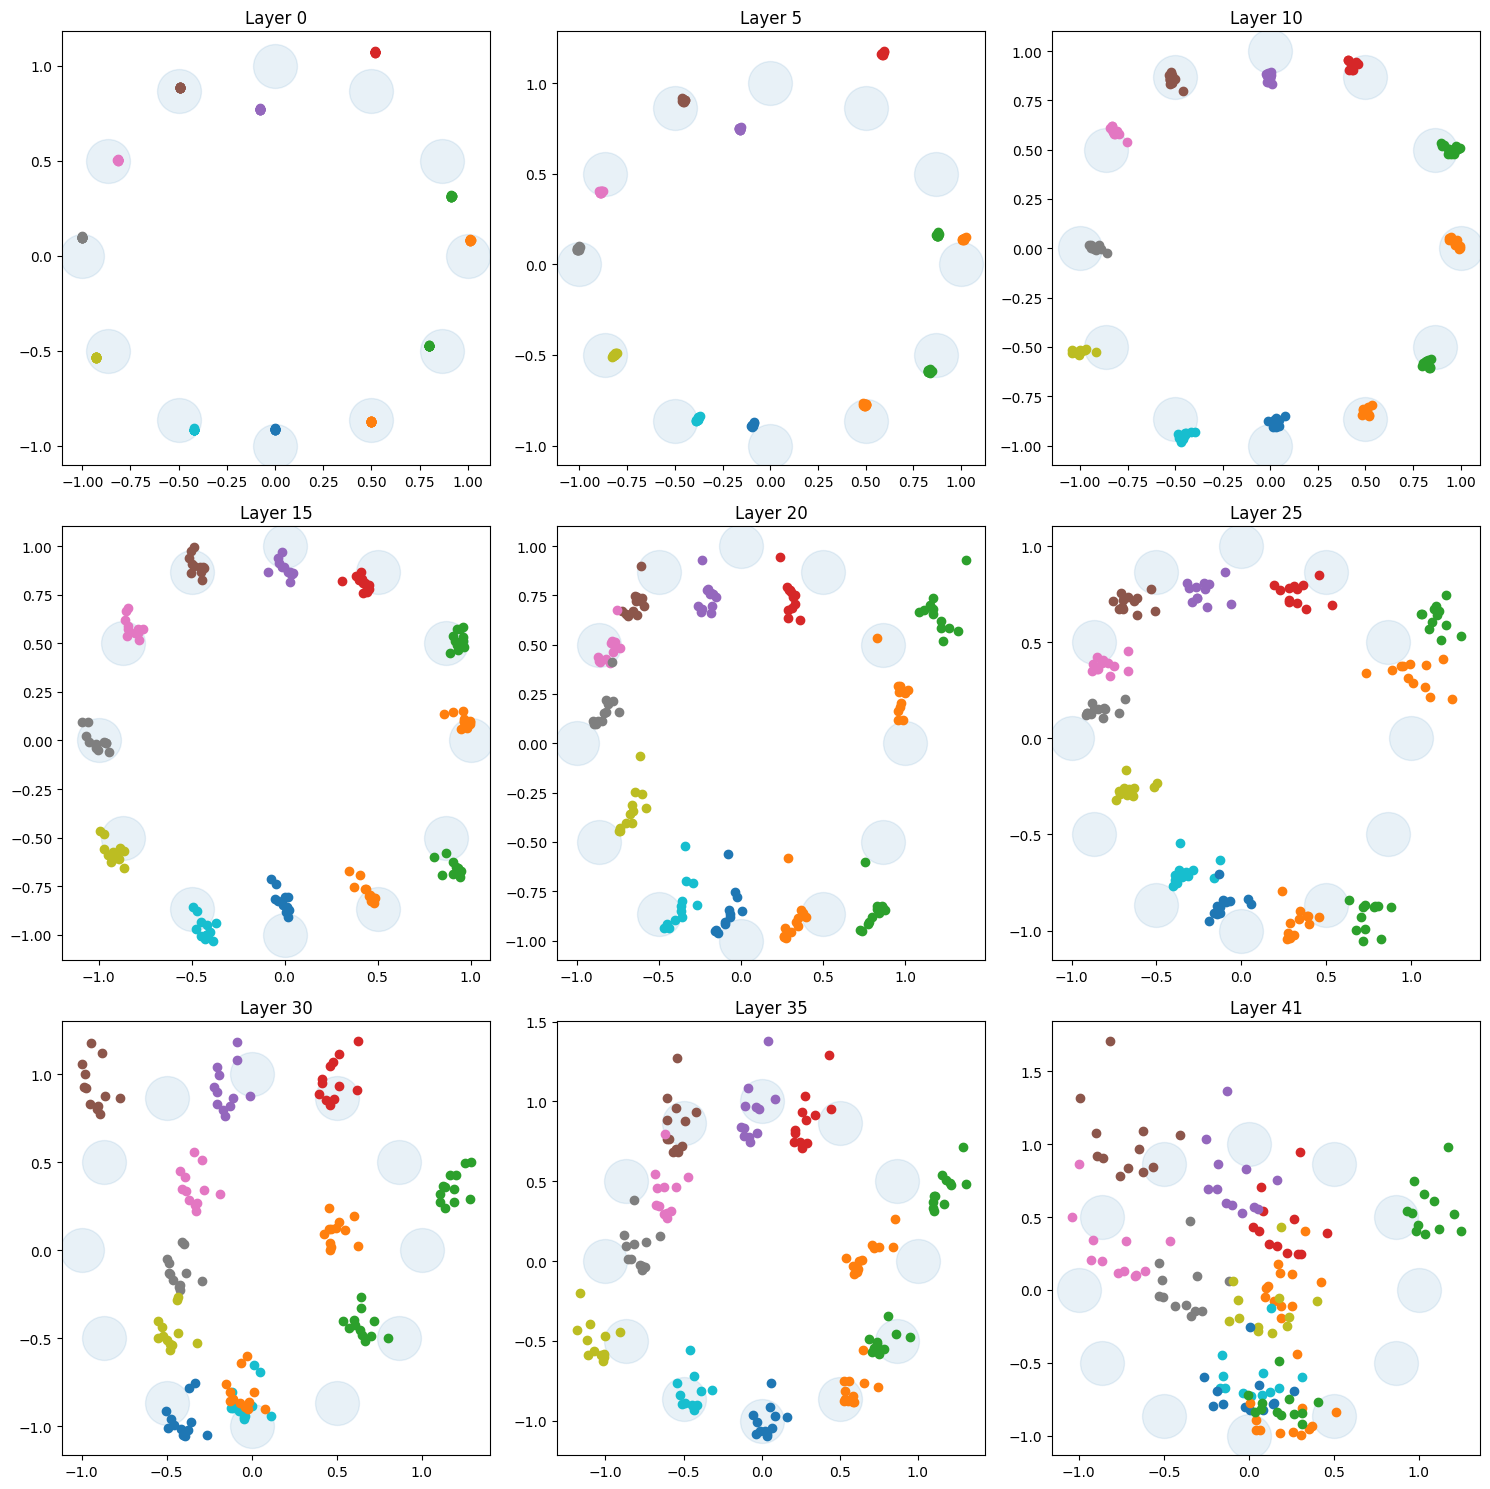

In [ ]:
visualize_linear_probes(month_task, 9)

We now use the projection matrix to replace to show circular representation in the residual stream is causually connected to the output of the model. For each \alpha token we have defined a point on the unit circle (`np.array([np.cos(w * np.arange(promptfn.count)), np.sin(w * np.arange(promptfn.count))])`). Using the inverse of our projection matrix we can transform this point back into the 5 dimensional PCA subspace and then transform that back into the residual stream space. That process however would only inject information on the \alpha token into the residual stream, and would destroy all the context provided by the rest of the prompt (`Let's do some week math. Two days from ...`).

However we cannot just add the circle projection to the existing residual stream as we did in the previous PCA(k=5) intervention. We want to show that the circular representation is causually connected to the model output. It might be that other subspaces of the residual stream carry the information that is necessary to perform the calendar calculation.

In order to include context information in a manner that ensures no other subspace of the residual stream can interfere, we will add the circle projection to the average of the residuals of the layer.

This process complicates the linear algebra involved in the intervention. In particular the output is calculated by adding the projection from the circle to the average but then subtracting the contribution of the average in the circle space. The calculation involves the following steps:
1. circle contribution: project circle points into PCA(k=5), then project into the residual stream space
2. average contribution: project the average residuals into PCA(k=5), project into the circle space, then project back into PCA(k=5) and then into the residual stream space

In the calculation below we will be using QR-decomposition to calculate the inverse of the projection matrix. This is a numerically stable method to calculate the inverse of a matrix.

In [256]:
def project_circle_points(promptfn, residuals, points):
  probe = train_linear_probe(promptfn, residuals)
  q, r  = np.linalg.qr(probe)
  avg   = np.mean(residuals, axis=0)
  pca   = PCA(n_components=5).fit(residuals)

  circles_comp = points @ np.linalg.inv(r) @ q.T @ pca.components_
  avg_comp     = avg @ pca.components_.T @ q @ q.T @ pca.components_

  return avg + circles_comp - avg_comp

def circle_projection_replace(promptfn, residuals):
  w       = 2 * np.pi / promptfn.count
  circles = np.array([np.cos(w * promptfn.a_values), np.sin(w * promptfn.a_values)]).T
  clean_i = patching_params(promptfn)[3]

  return project_circle_points(promptfn, residuals, circles[clean_i])

weekday_circle_replace = patching_experiment(weekday_task, circle_projection_replace)
month_circle_replace   = patching_experiment(month_task, circle_projection_replace)

100%|██████████| 42/42 [8:58:13<00:00, 768.90s/it]    


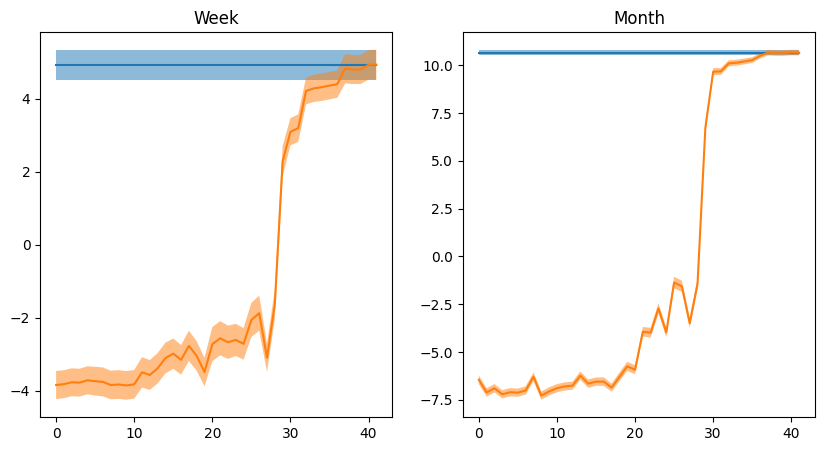

In [257]:
intervention_plot(weekday_circle_replace, month_circle_replace)

### Putting it all together

Below we plot all interventions on the same graph. We see the effect of the PCA and circle projection interventions lies between the average and complete layer replacement interventions. Our experiments suggest that the calculation of the output token occurs somewhere around layer 30 as after that the effect of the intervention disappears. The following argument is limited to the processing in the layers before that point.

In the case of averaging the residuals we lose most of the contextual information and all output tokens are equally likely hence the logit difference is zero. In the case of the complete layer replacement we essentially swap out the input token and therefore we see a sign swap in the logit difference.

The PCA(k=5) and circle projection show a strong effect that is between the averaging case and the complete layer replacement. The relevant feature of this result is that the circle projection has an effect as strong as the PCA(k=5) projection, in some cases even stronger than it, particularly in the month task. This strongly suggests that the circular representation is causally connected to the model output.

Note this is circumstantial evidence because we have not identified the exact mechanism that connects the circular representation to the output token.

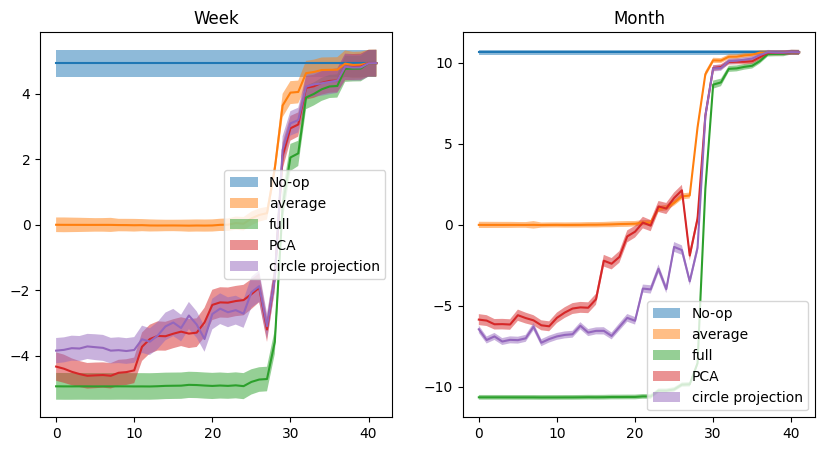

In [266]:
intervention_plot([("average", weekday_average_replace), ("full", weekday_full_replace), ("PCA", weekday_pca_replace), ("circle projection", weekday_circle_replace)], [("average", month_average_replace), ("full", month_full_replace), ("PCA", month_pca_replace), ("circle projection", month_circle_replace)])

## Off-distribution experiments

We investigate in more detail how the circular representations are used. We now do a grid sweep over the circle we surface of the circle we fitted in the previous section.

In [575]:
def circle_points(num):
  rs     = 2*(np.linspace(0, 1, num)**0.8)
  phis   = np.linspace(0, 2*np.pi, num)
  grid   = np.meshgrid(rs, phis)
  x      = (grid[0] * np.cos(grid[1])).reshape(-1)
  y      = (grid[0] * np.sin(grid[1])).reshape(-1)
  return np.column_stack((x, y))

def highest_logit_in_filled_circle_for_layer_and_offset(promptfn, layer, offset, embeds):
  def replacement_hook_fn(acts):
    def hook(array, label=None):
      if label == f"blocks.{layer}.hook_resid_post":
        array[:, promptfn.a_index] = acts
      return array
    return hook

  def patched_model_output(prompt, acts):
    hook   = replacement_hook_fn(layer, acts)
    tokens = mx.array(tokenizer.encode(prompt))[None]
    return model(tokens, hook=hook)[0, -1, promptfn.domain_tokens]

  outputs = np.array([patched_model_output(promptfn(0, offset), circle_embed) for circle_embed in embeds])
  return outputs.argmax(axis=1)

def highest_logit_in_filled_circle_for_layer(promptfn, layer, points):
  residuals = extract_residuals(promptfn)[layer]
  patches   = project_circle_points(promptfn, residuals, points)
  return [highest_logit_in_filled_circle_for_layer_and_offset(promptfn, layer, i, patches) for i in tqdm(range(promptfn.count))]

circle = circle_points(200)
week_filled_circle_layer10 = highest_logit_in_filled_circle_for_layer(weekday_task, 10, circle)

100%|██████████| 7/7 [9:16:40<00:00, 4771.48s/it]  


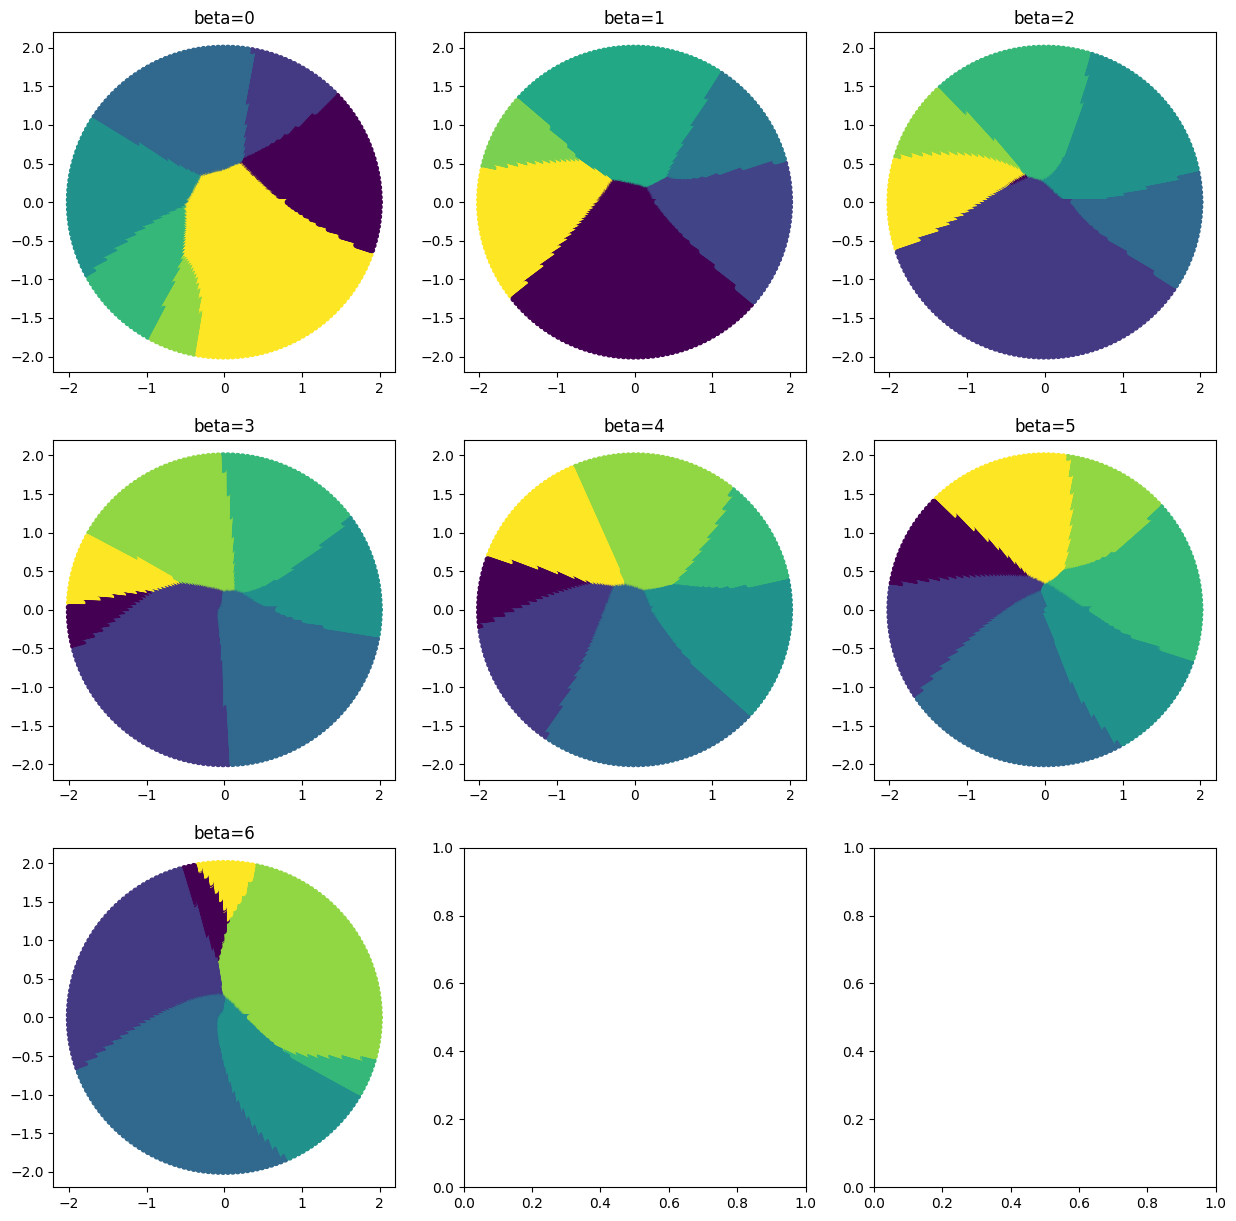

In [584]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, (layer, ax) in enumerate(zip(week_filled_circle_layer10, axs.flatten())):
  ax.scatter(circle[:, 0], circle[:, 1], c=layer, s=12)
  ax.title.set_text(f"beta={i}")
plt.show()

# Discussion

In the Theory section we saw how the authors of the paper modified the Linear Superposition Hypothesis to account for multi-dimensional features. After that one of the authors of the original hypothesis referenced this modification (https://transformer-circuits.pub/2024/july-update/index.html#linear-representations) which we now summarize. In this post the author acknowledged that the original formulation was misleading as it talked about representation directions. He then clarified that the use of the term "linear representation" which consists of two requirements. The representation of information in the residual stream can be considered "linear" similar to the Linear Superposition Hypothesis if it obeys them. The distinction between one-dimensional and multi-dimensional features does not change the essence of the hypothesis.

Firstly, features should be composable via addition. This is an important aspect of the mathematical meaning of linear. It allows us to study the features in isolation and then combine them to understand the representation of a token. The second requirement is that the intensity of a feature should be represented by magnitude. This magnitude can also be considered the model's confidence that a feature is present.

The second requirement significantly constrains the geometry of the representation of multidimensional features and the manifolds they form. Each point on the feature manifold can be identified with a certain intensity. This intensity can be scaled back to zero, such that all features collapse into a single point. This means that semantic differences can only be encoded by changes orthogonal to the ray connecting the common zero point and any point on the manifold. Another way of saying this is that the semantic value of a feature must be encoded in its angle.

Interestingly we see some of this angular encoding in the Off-Distribution experiments in the previous section.

# Summary & project ideas

In this tutorial we investigated how information is represented in the residual stream of Transformer language model. We first investigated a toy model where we discovered that SAEs can distinguish between different circles in a high dimensional space. These were then called multi-dimensional features. In the Theory section we then formalized how these features are represented by sets of almost orthogonal vectors. We also discussed the impact of multi-dimensional features on the capacity of a language model. Based on the theoretical motivation we proceeded in the Clustering section to search for multi-dimensional in a real language model, Gemma 2 9B, and identified the set of weekdays to be represented by a cluster of dictionary elements. Analysing this cluster we found that this representation formed a circle in the residual stream. Using activation patching, ie the targeted replacement of parts of the residual stream, we showed that the circular representation is causally connected to the output of the model.

The paper summarised in this tutorial sparked a discussion about the key assumption underlying the work on SAE's. The so-called Linear Superposition Hypothesis also known as Linear Representation Hypothesis argues that the representation of a token in the residual stream of a transformer is mathematically linear. This assumption radically simplifies the task of understanding the inner workings of a language model. Without it features cannot be studied in isolation, but rather the interaction between different parts of the residual stream must be considered. No definitive proof has been given either way so far.

In this tutorial we focussed on a subset of the paper used as its basis. The following parts were not covered:
* the statistical requirements for a multi-dimensional feature to be meaningful were only briefly mentioned. The authors go into much more detail and develop techniques to verify these requirements.
* the authors also present a novel technique to explain the function of a circuit in terms of mathematical functions. Allows verifying exactly where in the model the calculation investigated in this tutorial is performed and also providing additional evidence that the circular representation is causally connected to the output of the model.

Writing this tutorial several ideas of how to continue the work came to mind:
1. Relate the SAE dictionary elements to the representation space. In the off-distribution experiments we saw complicated patterns for which areas of the residual stream cause a certain output. Can these be explained using the SAE dictionary elements?
2. Find more feature clusters and apply the intervention technique to them. For example looking at the clusters in the Gemma 2 model we found one cluster that describes the scientific disciplines (physical, medical psychological, historical, etc). It would be interesting to see if this cluster is also represented in a circular fashion.
3. Investigate the prevalence of multi-dimensional features. The Linear Superposition Hypothesis provides an exponential increase in the possible features, which is counteracted by the worst-case exponential decrease in capacity for multi-dimensional features. How does this net out?